# W261 Machine Learning At Scale  

## Final Project - Flights Prediction 

### Project Team 26 

##### Hanyu Dai,  Edward Tong,  Shishir Agarwal,  Praveen Kasireddy

# Table Of Contents  

1. Executive Summary   
a. Background  
b. Problem Statement  
c. Reseach Questions  
d. Evaluation Metrics   
2. Overall Approach  
3. Exploratory Data Analysis  
3.1 Datasets  
3.2 Data Loading  
3.3 Data Pre-processing  
3.4 Data Exploration
4. Algorithm Exploration and Implementation  
4.1 Features Selection  
4.2 Basic Models  
4.2.1 Logistics Regression  
4.2.2 Linear Regression  
4.3 Advance Models  
4.3.1 Decision Tree    
4.3.2 Random Forest    
4.3.3 Gradient Boosting   
5. Performance and Scalability    
6. Limitations and Challenges      
7. Conclusions   
8. Application of Course Concepts    
9. Reference

# 1. Executive Summary  

#### a. Background  

From the BTS information, it is found Chicago and Atlanta to be the most busiest US airports. For example in 2018, O’Hare handled more than 83.4 million passengers and on average 1,500 flight arrivals and 1,500 flight departures per day. Moreover, FAA information [1] also stated, flights delayed are estimated to have cost the airlines several billion dollars additional expense. Delays also drive the need for extra gates and ground personnel and impose costs on airline customers in the form of lost productivity, wages and goodwill. FAA/Nextor estimated the annual costs of delays (direct cost to airlines and passengers, lost demand, and indirect costs) in 2018 to be $28 billion.
 
Flight delays are used to be caused by number of categories reported by the carrier to the BTS, delays caterories are including Air Carrier, National Aviation System, Weather, Late-Arriving Aircraft and Security.  
As the flight delay will have significant impacts to the carriers, passengers and airport control, it is therefore an initative to study and analysis flights delay with prediction result for the keystake holders to make data driven decision to minimize their impacts. 

The scope of this project is to use cloud infrastructure and Machine Learning technique to predict US airports flights delay in advance, flight and weather data between 2015-2019 are being used and the main objectives are to minimize the cost incur due to flight delay, execute the planned operational procedure for the event when arise, and to sustain/improve customer satisfaction.

Moreover, this project is focus on the departure delay with origin, together with weather conditions at origin and destination airports. Flight delay threshold of 15-minutes is used, that is flight is only considered delayed if the actual departure time is more than 15 minutes against the CRS schedule. The prediction will focus on flight schedule 2-hours ahead of the departure time; so that the prediction results will allow respective keystake holders to make decisions and actions such as regroup their operations and give passengers heads-up on the delay, passengers may take another flights or reschedule the flight. 

#### b. Problem Statement

What are the problems caused by the flights schedule change? Who and What will be the impacts?   

The flights schedule change will have either positive (ahead) or negative (delay) impacts, in particular delayed schedule will have impacts on airlines and airports operations, passengers inconvenience and economic losses. 


#### c. Research Questions  

Our research questions are:  

i. Flight delay or no delay due to weather conditions with the assumption of flight schedule delay is more than 15 minutes of the Computer Reservation System CRS schedule.  
ii. The average and maximum time the flights are delayed  
iii. Which are the top 5 trips (origin and dest airports) have flights delayed       
iv. The number of no delay versus delayed flights    


#### d. Evaluation Metrics 

The classification of delay is defined as following:

Flight delayed is positive class and negative class means flight has NO DELAYED. We also look into no. of metrics for evaluating the algorithms from business perspective.    

Most studies would use accuracy as the performance measurement of the prediction model, however, in veiw of the class imbalanced datasets, where there is a significant disparity between the number of positive and negative labels, so accuracy may be a misleading metric for this case.

Instead , precision and recall are being used to examine and evaluate the effectivness of our models, nevertheless precision and recall are often in tension, that is if we fine tune to improve precision typically will reduce recall and vice versa.

What does this mean from business perspective and we shall use an example with confusion matrix to explain it further. 

For a case of 100 delay/no delay,, 91 are NO DELAY (90 TNs and 1 FP) and 9 are DELAYED (1 TP and 8 FNs).
Of the 91 NO DELAY , the model correctly identifies 90 NO DELAY. That's good. However, of the 9 DELAYED,the model only correctly identifies 1 as DELAYED — a terrible outcome, as 8 out of 9 DELAYED is precdicted incorrectly.  

With the above, the model accuracy obtained is:    
                       Accuracy = (TP+TN) /(TP+TN+FP+FN) = (1+90)/(1+90+1+8)= 0.91   
                       Precision = TP / (TP + FP) = 1/(1+1) = 0.5   
                       Recall = TP / (TP + FN) = 1/(1+8) = 0.11   

Though a high number of accuracy is obtained, it is not a good indicator for the keystake holders, TP and TN are also a good indicator for them, they can plan ahead and minimize cost, inconvenience and economic impacts.

But both FP and FN are bad and will incur cost and impacts which should be avoided. In particular, FP will incur unnecessary cost and arrangement which is even worse than FN. Therefore, our evaluation metrics on a model would base on the precision value or a lower FP as the recommended model to be adopted for prediction.

# 2. Overall Approach

<img src ='/files/shared_uploads/edwardtong@ischool.berkeley.edu/EDA_Approach-1.png' width='800'>

# 3. Exploratory Data Analysis (EDA)

#### 3.1 Datasets

The data for this project comes in the form of two (BIG) tables and the project will focus on the entire flight history for 2015-2019:  

3.1.1. Flights table:  

This is a subset of the passenger flight's on-time performance data taken from the TranStats data collection available from the U.S. Department of Transportation (DOT)
http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time

3.1.2 Weather table: 

A weather table  has been pre-downloaded from the National Oceanic and Atmospheric Administration repository  to S3 in the form of  parquet files (thereby enabling pushdown querying and efficient joins). 


Besides of the flight and weather dataset, there is also a Station dataset and the one obtained from openflights( openflights.org) for IATA code map with timezone.  

3.1.3 Time Zones data: 

As the airlines data is given in localtimezone, we need to convert all times to UTC and to get the timezone infomration of each airport, we are using openlights.org data.

The timezone data is downloaded from https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.da

#### 3.2 Data loading

In [0]:
# load and import librabies for data manipulation , processing, modeling and evalution
import re
import os
import numpy as np
import pandas as pd
import math
import time
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import ast
import pytz
import sys

from pytz import timezone
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as f
from pyspark.sql import types
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, TimestampType
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import last
from pyspark.sql.functions import isnan, when, count, col


from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler,StandardScaler,OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

from pyspark.mllib.util import MLUtils
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from pyspark.mllib.regression import LabeledPoint

from sklearn.metrics import classification_report, confusion_matrix
from graphframes import *
%matplotlib inline

In [0]:
sqlContext = SQLContext(sc)
sc

Out[2]:

SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 spark://10.99.230.93:7077 
 AppName 
 Databricks Shell

##### 3.2.1 Load Raw Data

In [0]:
display(dbutils.fs.ls("dbfs:/mnt/mids-w261/datasets_final_project/"))

path,name,size
dbfs:/mnt/mids-w261/datasets_final_project/airlines/,airlines/,0
dbfs:/mnt/mids-w261/datasets_final_project/airlines_data/,airlines_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/allstate-claims-severity.zip,allstate-claims-severity.zip,51204863
dbfs:/mnt/mids-w261/datasets_final_project/dac.tar.gz,dac.tar.gz,4576820670
dbfs:/mnt/mids-w261/datasets_final_project/kdd-cup-2014-predicting-excitement-at-donors-choose.zip,kdd-cup-2014-predicting-excitement-at-donors-choose.zip,971133938
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/,parquet_airlines_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_3m/,parquet_airlines_data_3m/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/,parquet_airlines_data_6m/,0
dbfs:/mnt/mids-w261/datasets_final_project/porto-seguro-safe-driver-prediction.zip,porto-seguro-safe-driver-prediction.zip,80247571
dbfs:/mnt/mids-w261/datasets_final_project/walmart-recruiting-trip-type-classification.zip,walmart-recruiting-trip-type-classification.zip,11510035


In [0]:
display(dbutils.fs.ls("dbfs:/mnt/mids-w261/final_project_team_26/"))

path,name,size
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data.parquet/,airlines_weather_data.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_2015_v3.parquet/,airlines_weather_data_2015_v3.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_2015_v3_Dec01.parquet/,airlines_weather_data_2015_v3_Dec01.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_2015_v3_Nov28.parquet/,airlines_weather_data_2015_v3_Nov28.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_2015_v3_Nov30.parquet/,airlines_weather_data_2015_v3_Nov30.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_2015_v4.parquet/,airlines_weather_data_2015_v4.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_2015_v4_Dec01.parquet/,airlines_weather_data_2015_v4_Dec01.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_2015_v4_Dec05_praveen.parquet/,airlines_weather_data_2015_v4_Dec05_praveen.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_2019_v4.parquet/,airlines_weather_data_2019_v4.parquet/,0
dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_3m.parquet/,airlines_weather_data_3m.parquet/,0


In [0]:
display(dbutils.fs.ls("dbfs:/mnt/mids-w261/datasets_final_project/weather_data"))

path,name,size
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/teamjvml1/,teamjvml1/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather-miss.parquet/,weather-miss.parquet/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2015a.parquet/,weather2015a.parquet/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2016a.parquet/,weather2016a.parquet/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2017a.parquet/,weather2017a.parquet/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2018a.parquet/,weather2018a.parquet/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2019a.parquet/,weather2019a.parquet/,0


In [0]:
# load Flight dataset
airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/201*.parquet")
airlines.printSchema()

root
-- YEAR: integer (nullable = true)
-- QUARTER: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- FL_DATE: string (nullable = true)
-- OP_UNIQUE_CARRIER: string (nullable = true)
-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- OP_CARRIER_FL_NUM: integer (nullable = true)
-- ORIGIN_AIRPORT_ID: integer (nullable = true)
-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
-- ORIGIN: string (nullable = true)
-- ORIGIN_CITY_NAME: string (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- ORIGIN_STATE_FIPS: integer (nullable = true)
-- ORIGIN_STATE_NM: string (nullable = true)
-- ORIGIN_WAC: integer (nullable = true)
-- DEST_AIRPORT_ID: integer (nullable = true)
-- DEST_AIRPORT_SEQ_ID: integer (nullable = true)
-- DEST_CITY_MARKET_ID: integer (nullable = true)
-- DEST: string (nullable = true)
-- DEST_CITY_NAME: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEST_STATE_FIPS: integer (nullable = true)
-- DEST_STATE_NM: string (nullable = true)
-- DEST_WAC: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- DEP_TIME: integer (nullable = true)
-- DEP_DELAY: double (nullable = true)
-- DEP_DELAY_NEW: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- DEP_DELAY_GROUP: integer (nullable = true)
-- DEP_TIME_BLK: string (nullable = true)
-- TAXI_OUT: double (nullable = true)
-- WHEELS_OFF: integer (nullable = true)
-- WHEELS_ON: integer (nullable = true)
-- TAXI_IN: double (nullable = true)
-- CRS_ARR_TIME: integer (nullable = true)
-- ARR_TIME: integer (nullable = true)
-- ARR_DELAY: double (nullable = true)
-- ARR_DELAY_NEW: double (nullable = true)
-- ARR_DEL15: double (nullable = true)
-- ARR_DELAY_GROUP: integer (nullable = true)
-- ARR_TIME_BLK: string (nullable = true)
-- CANCELLED: double (nullable = true)
-- CANCELLATION_CODE: string (nullable = true)
-- DIVERTED: double (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)
-- ACTUAL_ELAPSED_TIME: double (nullable = true)
-- AIR_TIME: double (nullable = true)
-- FLIGHTS: double (nullable = true)
-- DISTANCE: double (nullable = true)
-- DISTANCE_GROUP: integer (nullable = true)
-- CARRIER_DELAY: double (nullable = true)
-- WEATHER_DELAY: double (nullable = true)
-- NAS_DELAY: double (nullable = true)
-- SECURITY_DELAY: double (nullable = true)
-- LATE_AIRCRAFT_DELAY: double (nullable = true)
-- FIRST_DEP_TIME: integer (nullable = true)
-- TOTAL_ADD_GTIME: double (nullable = true)
-- LONGEST_ADD_GTIME: double (nullable = true)
-- DIV_AIRPORT_LANDINGS: integer (nullable = true)
-- DIV_REACHED_DEST: double (nullable = true)
-- DIV_ACTUAL_ELAPSED_TIME: double (nullable = true)
-- DIV_ARR_DELAY: double (nullable = true)
-- DIV_DISTANCE: double (nullable = true)
-- DIV1_AIRPORT: string (nullable = true)
-- DIV1_AIRPORT_ID: integer (nullable = true)
-- DIV1_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV1_WHEELS_ON: integer (nullable = true)
-- DIV1_TOTAL_GTIME: double (nullable = true)
-- DIV1_LONGEST_GTIME: double (nullable = true)
-- DIV1_WHEELS_OFF: integer (nullable = true)
-- DIV1_TAIL_NUM: string (nullable = true)
-- DIV2_AIRPORT: string (nullable = true)
-- DIV2_AIRPORT_ID: integer (nullable = true)
-- DIV2_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV2_WHEELS_ON: integer (nullable = true)
-- DIV2_TOTAL_GTIME: double (nullable = true)
-- DIV2_LONGEST_GTIME: double (nullable = true)
-- DIV2_WHEELS_OFF: integer (nullable = true)
-- DIV2_TAIL_NUM: string (nullable = true)
-- DIV3_AIRPORT: string (nullable = true)
-- DIV3_AIRPORT_ID: integer (nullable = true)
-- DIV3_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV3_WHEELS_ON: integer (nullable = true)
-- DIV3_TOTAL_GTIME: double (nullable = true)
-- DIV3_LONGEST_GTIME: double (nullable = true)
-- DIV3_WHEELS_

In [0]:
# Raw flight data size
print("Flight dataset no. of data rows:", f'{airlines.count():,}')
print("Flight dataset no. of features columns:", len(airlines.columns))

In [0]:
# load Weather dataset
weather = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/*.parquet")
weather.printSchema()
#f'{weather.count():,}'

root
-- STATION: string (nullable = true)
-- DATE: timestamp (nullable = true)
-- SOURCE: short (nullable = true)
-- LATITUDE: double (nullable = true)
-- LONGITUDE: double (nullable = true)
-- ELEVATION: double (nullable = true)
-- NAME: string (nullable = true)
-- REPORT_TYPE: string (nullable = true)
-- CALL_SIGN: string (nullable = true)
-- QUALITY_CONTROL: string (nullable = true)
-- WND: string (nullable = true)
-- CIG: string (nullable = true)
-- VIS: string (nullable = true)
-- TMP: string (nullable = true)
-- DEW: string (nullable = true)
-- SLP: string (nullable = true)
-- AW1: string (nullable = true)
-- GA1: string (nullable = true)
-- GA2: string (nullable = true)
-- GA3: string (nullable = true)
-- GA4: string (nullable = true)
-- GE1: string (nullable = true)
-- GF1: string (nullable = true)
-- KA1: string (nullable = true)
-- KA2: string (nullable = true)
-- MA1: string (nullable = true)
-- MD1: string (nullable = true)
-- MW1: string (nullable = true)
-- MW2: string (nullable = true)
-- OC1: string (nullable = true)
-- OD1: string (nullable = true)
-- OD2: string (nullable = true)
-- REM: string (nullable = true)
-- EQD: string (nullable = true)
-- AW2: string (nullable = true)
-- AX4: string (nullable = true)
-- GD1: string (nullable = true)
-- AW5: string (nullable = true)
-- GN1: string (nullable = true)
-- AJ1: string (nullable = true)
-- AW3: string (nullable = true)
-- MK1: string (nullable = true)
-- KA4: string (nullable = true)
-- GG3: string (nullable = true)
-- AN1: string (nullable = true)
-- RH1: string (nullable = true)
-- AU5: string (nullable = true)
-- HL1: string (nullable = true)
-- OB1: string (nullable = true)
-- AT8: string (nullable = true)
-- AW7: string (nullable = true)
-- AZ1: string (nullable = true)
-- CH1: string (nullable = true)
-- RH3: string (nullable = true)
-- GK1: string (nullable = true)
-- IB1: string (nullable = true)
-- AX1: string (nullable = true)
-- CT1: string (nullable = true)
-- AK1: string (nullable = true)
-- CN2: string (nullable = true)
-- OE1: string (nullable = true)
-- MW5: string (nullable = true)
-- AO1: string (nullable = true)
-- KA3: string (nullable = true)
-- AA3: string (nullable = true)
-- CR1: string (nullable = true)
-- CF2: string (nullable = true)
-- KB2: string (nullable = true)
-- GM1: string (nullable = true)
-- AT5: string (nullable = true)
-- AY2: string (nullable = true)
-- MW6: string (nullable = true)
-- MG1: string (nullable = true)
-- AH6: string (nullable = true)
-- AU2: string (nullable = true)
-- GD2: string (nullable = true)
-- AW4: string (nullable = true)
-- MF1: string (nullable = true)
-- AA1: string (nullable = true)
-- AH2: string (nullable = true)
-- AH3: string (nullable = true)
-- OE3: string (nullable = true)
-- AT6: string (nullable = true)
-- AL2: string (nullable = true)
-- AL3: string (nullable = true)
-- AX5: string (nullable = true)
-- IB2: string (nullable = true)
-- AI3: string (nullable = true)
-- CV3: string (nullable = true)
-- WA1: string (nullable = true)
-- GH1: string (nullable = true)
-- KF1: string (nullable = true)
-- CU2: string (nullable = true)
-- CT3: string (nullable = true)
-- SA1: string (nullable = true)
-- AU1: string (nullable = true)
-- KD2: string (nullable = true)
-- AI5: string (nullable = true)
-- GO1: string (nullable = true)
-- GD3: string (nullable = true)
-- CG3: string (nullable = true)
-- AI1: string (nullable = true)
-- AL1: string (nullable = true)
-- AW6: string (nullable = true)
-- MW4: string (nullable = true)
-- AX6: string (nullable = true)
-- CV1: string (nullable = true)
-- ME1: string (nullable = true)
-- KC2: string (nullable = true)
-- CN1: string (nullable = true)
-- UA1: string (nullable = true)
-- GD5: string (nullable = true)
-- UG2: string (nullable = true)
-- AT3: string (nullable = true)
-- AT4: string (nullable = true)
-- GJ1: string (nullable = true)
-- MV1: string (nullable = true)
-- GA5: string (nullable = true)
-- CT2: string (nullable = true)
-- CG2: string

In [0]:
# Raw weather data size
print("Weather dataset no. of data rows:", f'{weather.count():,}')
print("Weather dataset no. of features columns:", len(weather.columns))

Weather dataset no. of data rows: 630,904,436
Weather dataset no. of features columns: 177

In [0]:
# load Station dataset
stations = spark.read.option("header", "true").csv("dbfs:/mnt/mids-w261/DEMO8/gsod/stations.csv.gz")
stations.printSchema()

root
-- usaf: string (nullable = true)
-- wban: string (nullable = true)
-- name: string (nullable = true)
-- country: string (nullable = true)
-- state: string (nullable = true)
-- call: string (nullable = true)
-- lat: string (nullable = true)
-- lon: string (nullable = true)
-- elev: string (nullable = true)
-- begin: string (nullable = true)
-- end: string (nullable = true)

Out[14]: '29,771'

In [0]:
print("Station dataset no. of data rows:", f'{stations.count():,}')
print("Station dataset no. of features columns:", len(stations.columns))

Station dataset no. of data rows: 29,771
Station dataset no. of features columns: 11

In [0]:
#load additional timezone dataset downloaded from openflights and used to maps airport IATA code to timezone
tz_data = spark.read.format("csv").load("dbfs:/mnt/mids-w261/final_project_team_26/timezone_data.csv")

#### 3.3 Data Pre-Processing

##### 3.3.1 Create flight data subset with selected features

In [0]:
# Ceate additional derived fields:   

# PAIR for flight from Origin to Destination
# FL_TIMESTAMP from FL_DATE and CRS_DEP_TIME
# HOUR_OF_DAY from FL_TIMESTAMP
# FL_TIMESTAMP_EARLY which is 2 hours before the FL_TIMESTAMP
# FL_TIMESTAMP_EARLY_UTC which is 2 hours before the FL_TIMESTAMP but in UTC
# DEP_DEL_LN which is natural log of DEP_DELAY. For null values fill it with zero

keep_columns = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','OP_CARRIER','FL_DATE', 'TAIL_NUM', 'AIR_TIME', 'ORIGIN', 'ORIGIN_STATE_ABR','DEST','DEST_STATE_ABR','DEP_DELAY','DEP_DEL15',"CRS_DEP_TIME",'DEP_TIME','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','DEP_DELAY_NEW', 'CANCELLED','DIVERTED']
# airlines_data = airlines_atl_ord_q12015.select(*keep_columns)

################# Comment/Uncomment below to toggle b/w train and test dataset#####################
airlines_data = airlines.where('YEAR < 2019').select(*keep_columns)
#airlines_data = airlines.where('YEAR == "2019"').select(*keep_columns)

airlines_data = airlines_data.join(tz_data, airlines_data.ORIGIN == tz_data._c4).select(airlines_data["*"],(tz_data._c11).alias("timezone"))


airlines_data = airlines_data.withColumn("CRS_DEP", f.lpad(airlines_data.CRS_DEP_TIME,4,'0'))
airlines_data = airlines_data.withColumn("CRS_DEP", f.concat(f.col("FL_DATE"), f.lit("-"), f.col("CRS_DEP")))
airlines_data = airlines_data.withColumn('FL_TIMESTAMP',f.to_timestamp("CRS_DEP", "yyyy-MM-dd-HHmm"))
airlines_data = airlines_data.withColumn('CRS_DEP',f.to_timestamp("CRS_DEP", "yyyy-MM-dd-HHmm"))
airlines_data = airlines_data.withColumn('CRS_DEP',f.to_utc_timestamp("CRS_DEP", airlines_data['timezone']))
airlines_data = airlines_data.withColumn('HOUR_OF_DAY',f.hour("CRS_DEP"))
airlines_data = airlines_data.withColumn("CRS_DEP_EARLY", f.date_trunc("hour", "CRS_DEP"))
airlines_data = airlines_data.withColumn("FL_TIMESTAMP_EARLY_UTC", airlines_data['CRS_DEP_EARLY'] - f.expr('INTERVAL 2 HOURS'))

airlines_data = airlines_data.withColumn("ACT_DEP", (f.unix_timestamp(airlines_data['CRS_DEP']) + 60*airlines_data['DEP_DELAY']).cast('timestamp'))
airlines_data = airlines_data.withColumn("CRS_ARR", (f.unix_timestamp(airlines_data['ACT_DEP']) + 60*airlines_data['CRS_ELAPSED_TIME']).cast('timestamp'))
airlines_data = airlines_data.withColumn("ACT_ARR", (f.unix_timestamp(airlines_data['ACT_DEP']) + 60*airlines_data['ACTUAL_ELAPSED_TIME']).cast('timestamp'))

airlines_data = airlines_data.withColumn("DEP_DEL_LN", f.log(f.col("DEP_DELAY")))
airlines_data = airlines_data.withColumn("DEP_DEL_LN", f.when(f.col("DEP_DEL_LN").isNull(),0.0).otherwise(f.col("DEP_DEL_LN")))

airlines_data = airlines_data.withColumn("PAIR", f.concat(f.col("ORIGIN"), f.lit("-"), f.col("DEST")))

In [0]:
# Drop Duplicate Flights columns
airlines_data = airlines_data.dropDuplicates(['OP_CARRIER','PAIR', 'CRS_DEP_EARLY', 'TAIL_NUM'])

In [0]:
# Raw flight data size
print("Flight dataset no. of data rows:", f'{airlines_data.count():,}')
print("Flight dataset no. of features columns:", len(airlines_data.columns))

Flight dataset no. of data rows: 24,323,928
Flight dataset no. of features columns: 32

In [0]:
# DEL_DELAY of last last flight

airlines_data = airlines_data.filter(airlines_data.TAIL_NUM.isNotNull())
airlines_data.registerTempTable("airlines_data")
airlines_data = sqlContext.sql("SELECT *, LAG(CRS_DEP) OVER (PARTITION BY TAIL_NUM ORDER BY CRS_DEP DESC) AS NXT_CRS_DEP, RANK() OVER (PARTITION BY TAIL_NUM ORDER BY CRS_DEP) AS rank FROM airlines_data")
airlines_data = airlines_data.withColumn('DEL_T',when((f.col('NXT_CRS_DEP').cast('long') - f.col('CRS_ARR').cast('long'))/60 <= 90, airlines_data.DEP_DELAY).otherwise(0))
w = Window().partitionBy().orderBy(*['TAIL_NUM', 'CRS_DEP'])
airlines_data = airlines_data.select("*", lag("DEL_T", offset=2).over(w).alias("LST_DELAY"))
airlines_data = airlines_data.withColumn('LST_DELAY',when(f.col('rank') == 1, 0).otherwise(f.col('LST_DELAY')))
airlines_data = airlines_data.withColumn('LST_DELAY',when(f.col('rank') == 2, 0).otherwise(f.col('LST_DELAY')))
#display(airlines_data.orderBy(['TAIL_NUM', 'CRS_DEP']))

In [0]:
airlines_data = airlines_data.where('CANCELLED == 0')
airlines_data = airlines_data.where('DIVERTED == 0')

In [0]:
#airlines_data = data
airlines_data = airlines_data.withColumn('ACT_DEP_DATE', to_date(col("ACT_DEP"),"yyyy-MM-dd"))
airlines_data = airlines_data.withColumn('ACT_DEP_HOUR', hour("ACT_DEP"))
airlines_data = airlines_data.withColumn('ACT_ARR_DATE', to_date(col("ACT_ARR"),"yyyy-MM-dd"))
airlines_data = airlines_data.withColumn('ACT_ARR_HOUR', hour("ACT_ARR"))

airlines_data = airlines_data.join(airlines_data.groupBy('ORIGIN','ACT_DEP_DATE','ACT_DEP_HOUR').count().withColumnRenamed("count", "outgoing_hour"), on=['ORIGIN','ACT_DEP_DATE','ACT_DEP_HOUR'], how='inner')

airlines_data = airlines_data.join(airlines_data.groupBy('DEST','ACT_ARR_DATE','ACT_ARR_HOUR').count().withColumnRenamed("DEST", "ORIGIN").withColumnRenamed("count", "incoming_hour"), on=['ORIGIN','ACT_ARR_DATE','ACT_ARR_HOUR'], how='inner')

# display(airlines_data.orderBy('ACT_DEP'))

In [0]:
# Check the airline_data dataset size after processing
print("Flight dataset no. of data rows:", f'{airlines_data.count():,}')
print("Flight dataset no. of features columns:", len(airlines_data.columns))

Flight dataset no. of data rows: 21,729,878
Flight dataset no. of features columns: 42

In [0]:
# Select features to be used for predicting flights delay

keep_columns = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','HOUR_OF_DAY','OP_CARRIER', 'PAIR', 'FL_DATE', 'FL_TIMESTAMP_EARLY_UTC', 'TAIL_NUM', 'AIR_TIME', 'ORIGIN','ORIGIN_STATE_ABR','DEST','DEST_STATE_ABR','DEP_DELAY','DEP_DEL_LN','DEP_DEL15','DEP_DELAY_NEW','FL_TIMESTAMP','CRS_ELAPSED_TIME','CRS_DEP_EARLY','LST_DELAY','incoming_hour','outgoing_hour']
#keep_columns = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','HOUR_OF_DAY','OP_CARRIER', 'PAIR', 'FL_DATE', 'FL_TIMESTAMP_EARLY_UTC', 'TAIL_NUM', 'AIR_TIME', 'ORIGIN','ORIGIN_STATE_ABR','DEST','DEST_STATE_ABR','DEP_DELAY','DEP_DEL_LN','DEP_DEL15','DEP_DELAY_NEW','FL_TIMESTAMP','CRS_DEP_EARLY']
airlines_data = airlines_data.select(*keep_columns)

In [0]:
airlines_data.printSchema()

root
-- YEAR: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- HOUR_OF_DAY: integer (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- PAIR: string (nullable = true)
-- FL_DATE: string (nullable = true)
-- FL_TIMESTAMP_EARLY_UTC: timestamp (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- AIR_TIME: double (nullable = true)
-- ORIGIN: string (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- DEST: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEP_DELAY: double (nullable = true)
-- DEP_DEL_LN: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- DEP_DELAY_NEW: double (nullable = true)
-- FL_TIMESTAMP: timestamp (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)
-- CRS_DEP_EARLY: timestamp (nullable = true)
-- LST_DELAY: double (nullable = true)
-- incoming_hour: long (nullable = false)
-- outgoing_hour: long (nullable = false)

##### 3.3.2 Create weather data subset with selected features

In [0]:
# Select Data from USAF weather stations
# weather_q12015 = weather.where((f.year('DATE') == "2015") & (f.month('DATE') <= 12))
# weather_q12015 = weather_q12015.where('SOURCE == 7')
# keep_columns = ['STATION', 'DATE', 'CALL_SIGN', 'WND', 'CIG', 'VIS', 'TMP','MA1']
# weather_data = weather_q12015.select(*keep_columns)

################# Comment/Uncomment below to toggle b/w train and test dataset#####################
weather_data = weather.where(f.year('DATE') < "2019")
#weather_data = weather.where(f.year('DATE') == "2019")

weather_data = weather.where('SOURCE == 7')
keep_columns = ['STATION', 'DATE', 'CALL_SIGN', 'WND', 'CIG', 'VIS', 'TMP','MA1']
weather_data = weather_data.select(*keep_columns)

In [0]:
# Split weather data into each field and choose the relevant fields

# Wind Speed 
weather_data = weather_data.withColumn("WND_Direction", f.split("WND",",")[0].cast(IntegerType()))
weather_data = weather_data.withColumn("WND_Speed", f.split("WND",",")[3].cast(IntegerType()))

# Sky Condition
weather_data = weather_data.withColumn("CIG_CeilingHeight", f.split("CIG",",")[0].cast(IntegerType()))

# Visibility
weather_data = weather_data.withColumn("VIS_Distance", f.split("VIS",",")[0].cast(IntegerType()))

# Air Temperature
weather_data = weather_data.withColumn("TMP_Air", f.split("TMP",",")[0].cast(IntegerType()))

# Atmospheric Pressure
weather_data = weather_data.withColumn("MA1_Altimeter", f.split("MA1",",")[0].cast(IntegerType()))
weather_data = weather_data.withColumn("MA1_Pressure", f.split("MA1",",")[2].cast(IntegerType()))

# drop and keep the relevant fields only
drop_columns = ['WND', 'CIG', 'VIS', 'TMP', 'MA1', 'AA1' ]
weather_data = weather_data.drop(*drop_columns)
weather_data = weather_data.dropna(how='all', subset=['WND_Direction','WND_Speed','CIG_CeilingHeight','VIS_Distance','TMP_Air','MA1_Altimeter','MA1_Pressure'])


In [0]:
weather_data.printSchema()

root
-- STATION: string (nullable = true)
-- DATE: timestamp (nullable = true)
-- CALL_SIGN: string (nullable = true)
-- WND_Direction: integer (nullable = true)
-- WND_Speed: integer (nullable = true)
-- CIG_CeilingHeight: integer (nullable = true)
-- VIS_Distance: integer (nullable = true)
-- TMP_Air: integer (nullable = true)
-- MA1_Altimeter: integer (nullable = true)
-- MA1_Pressure: integer (nullable = true)

In [0]:
# Change missing values into null values to easily pre-process null values
# from pyspark.sql.functions import col, when
weather_data = weather_data.withColumn('WND_Direction', when(col('WND_Direction') == '999', None).otherwise(col('WND_Direction')))
weather_data = weather_data.withColumn('WND_Speed', when(col('WND_Speed') == '9999', None).otherwise(col('WND_Speed')))
weather_data = weather_data.withColumn('CIG_CeilingHeight', when(col('CIG_CeilingHeight') == '99999', None).otherwise(col('CIG_CeilingHeight')))
weather_data = weather_data.withColumn('VIS_Distance', when(col('VIS_Distance') == '999999', None).otherwise(col('VIS_Distance')))
weather_data = weather_data.withColumn('TMP_Air', when(col('TMP_Air') == '9999', None).otherwise(col('TMP_Air')))
weather_data = weather_data.withColumn('MA1_Altimeter', when(col('MA1_Altimeter') == '99999', None).otherwise(col('MA1_Altimeter')))
weather_data = weather_data.withColumn('MA1_Pressure', when(col('MA1_Pressure') == '99999', None).otherwise(col('MA1_Pressure')))   

In [0]:
# Create window for every day worth of data and forward fill within 1-day window

weather_data = weather_data.withColumn('dt',f.to_date("DATE"))


# define the window
window = Window.partitionBy('STATION','dt')\
               .orderBy('DATE')\
               .rowsBetween(-250, 0)

# define the forward-filled column
filled_column = last(weather_data['WND_Direction'], ignorenulls=True).over(window)
weather_data = weather_data.withColumn('temp_WND_Direction', filled_column).drop('WND_Direction')
weather_data = weather_data.withColumnRenamed("temp_WND_Direction", "WND_Direction")

filled_column = last(weather_data['WND_Speed'], ignorenulls=True).over(window)
weather_data = weather_data.withColumn('temp_WND_Speed', filled_column).drop('WND_Speed')
weather_data = weather_data.withColumnRenamed("temp_WND_Speed", "WND_Speed")

filled_column = last(weather_data['CIG_CeilingHeight'], ignorenulls=True).over(window)
weather_data = weather_data.withColumn('temp_CIG_CeilingHeight', filled_column).drop('CIG_CeilingHeight')
weather_data = weather_data.withColumnRenamed("temp_CIG_CeilingHeight", "CIG_CeilingHeight")

filled_column = last(weather_data['VIS_Distance'], ignorenulls=True).over(window)
weather_data = weather_data.withColumn('temp_VIS_Distance', filled_column).drop('VIS_Distance')
weather_data = weather_data.withColumnRenamed("temp_VIS_Distance", "VIS_Distance")

filled_column = last(weather_data['TMP_Air'], ignorenulls=True).over(window)
weather_data = weather_data.withColumn('temp_TMP_Air', filled_column).drop('TMP_Air')
weather_data = weather_data.withColumnRenamed("temp_TMP_Air", "TMP_Air")

filled_column = last(weather_data['MA1_Altimeter'], ignorenulls=True).over(window)
weather_data = weather_data.withColumn('temp_MA1_Altimeter', filled_column).drop('MA1_Altimeter')
weather_data = weather_data.withColumnRenamed("temp_MA1_Altimeter", "MA1_Altimeter")

filled_column = last(weather_data['MA1_Pressure'], ignorenulls=True).over(window)
weather_data = weather_data.withColumn('temp_MA1_Pressure', filled_column).drop('MA1_Pressure')
weather_data = weather_data.withColumnRenamed("temp_MA1_Pressure", "MA1_Pressure")

In [0]:
# For each Duplicate calculate the max value and use the max value to rationalize the duplicates
weather_data = weather_data.withColumn("DATE", f.date_trunc("hour", "DATE"))
weather_data = weather_data.groupBy("STATION", "DATE").agg \
        (f.max("WND_Direction").alias("WND_Direction"), \
         f.max("WND_Speed").alias("WND_Speed"), \
         f.max("CIG_CeilingHeight").alias("CIG_CeilingHeight"), \
         f.max("VIS_Distance").alias("VIS_Distance"), \
         f.max("TMP_Air").alias("TMP_Air"), \
         f.max("MA1_Altimeter").alias("MA1_Altimeter"), \
         f.max("MA1_Pressure").alias("MA1_Pressure"))

In [0]:
# Handle Cyclical Variables
weather_data = weather_data.withColumn('WND_Direction_x', cos(col('WND_Direction')*np.pi/180))
weather_data = weather_data.withColumn('WND_Direction_y', sin(col('WND_Direction')*np.pi/180))

##### 3.3.3 Create stations data subset with selected features

In [0]:
# Select USA wheather stations operational for 2015 and beyond and remove non-operational stations
from pyspark.sql import functions as f
stations = stations.where(f.col('country') == "US")
stations = stations.withColumn("end", stations["end"].cast(IntegerType()))
stations = stations.withColumn("wban", stations["wban"].cast(IntegerType()))
stations = stations.where(f.col("call").isNotNull())
#stations = stations.where('wban != 99999')
stations = stations.where('usaf != "999999"')
stations = stations.where('end > 20150000')
stations = stations.withColumn("call",f.expr("substring(trim(call), -3,3)"))
#stations = stations.where(f.col('call').startswith('K'))
#stations = stations.dropDuplicates(['lat','lon'])

In [0]:
# Concat USAF and WBAN numbers to create stations numbers
stations = stations.select(f.concat('usaf','wban'),'country','state', 'call','lat','lon').withColumnRenamed("concat(usaf, wban)", "station")
#stations = stations.select(f.concat('usaf','wban'),'state', 'call','lat','lon').withColumnRenamed("concat(usaf, wban)", "station")
#stations = stations.select(f.concat('usaf','wban'),'state', 'call').withColumnRenamed("concat(usaf, wban)", "station")

In [0]:
display(stations.describe())

summary,station,country,state,call,lat,lon
count,2509,2509,2501,2509,2509,2509
mean,5.374572075709462E10,null,null,Infinity,39.37560940613782,-98.04726225587874
stddev,3.048841856299366E10,null,null,NaN,8.22568142102517,21.247899647391367
min,69015093121,US,AK,04V,17.7,-100.001
max,A51256451,US,WY,ZZV,71.283,174.1


In [0]:
#stations = stations.where(f.col("state").isNotNull())
stations = stations.dropna(how='any', subset=['state'])

In [0]:
display(stations.describe())

summary,station,country,state,call,lat,lon
count,2501,2501,2501,2501,2501,2501
mean,5.374485060068844E10,null,null,Infinity,39.397332666933146,-98.04200679728099
stddev,3.0487482284038563E10,null,null,NaN,8.206584155206622,21.253836684993008
min,69015093121,US,AK,04V,17.7,-100.001
max,A51256451,US,WY,ZZV,71.283,174.1


##### 3.3.4 Datasets (Flight, Weather and Stations) Joining

In [0]:
# Join flight data with stations data for ORIGIN Airport

airlines_data = airlines_data.join(stations, (stations.call==airlines_data.ORIGIN) & (stations.state==airlines_data.ORIGIN_STATE_ABR), 'inner')
airlines_data = airlines_data.withColumnRenamed("station", "station_origin")
airlines_data = airlines_data.withColumnRenamed("lat", "lat_origin")
airlines_data = airlines_data.withColumnRenamed("lon", "lon_origin")
#airlines_data = airlines_data.drop("country","state","call")
airlines_data = airlines_data.withColumnRenamed("state", "state_origin") # keep state for map plot in cmd92
airlines_data = airlines_data.drop("country","call")

# Join flight data with stations data for DEST Airport
airlines_data = airlines_data.join(stations, (stations.call==airlines_data.DEST) & (stations.state==airlines_data.DEST_STATE_ABR), 'inner')
airlines_data = airlines_data.withColumnRenamed("station", "station_dest")
airlines_data = airlines_data.withColumnRenamed("lat", "lat_dest")
airlines_data = airlines_data.withColumnRenamed("lon", "lon_dest")
#airlines_data = airlines_data.drop("country","state","call")
airlines_data = airlines_data.withColumnRenamed("state", "state_dest") # keep state for map plot in cmd92
airlines_data = airlines_data.drop("country","call")

In [0]:
airlines_data.count()

Out[142]: 21092537

In [0]:
# Join ORIGIN weather data with the flight data
weather_data_origin = weather_data.select(*(f.col(x).alias(x + '_origin') for x in weather_data.columns))
weather_data_origin.registerTempTable("weather")
airlines_data.registerTempTable("airlines")
airlines_weather_data = sqlContext.sql("SELECT * FROM airlines INNER JOIN weather ON airlines.station_origin = weather.STATION_origin AND airlines.CRS_DEP_EARLY = weather.DATE_origin")
#drop_columns = ['STATION_origin']
#airlines_weather_data = airlines_weather_data.drop(*drop_columns)

# Join DEST weather data with the flight data
weather_data_dest = weather_data.select(*(f.col(x).alias(x + '_dest') for x in weather_data.columns))
weather_data_dest.registerTempTable("weather")
airlines_weather_data.registerTempTable("airlines")
airlines_weather_data = sqlContext.sql("SELECT * FROM airlines INNER JOIN weather ON airlines.station_dest = weather.STATION_dest AND airlines.CRS_DEP_EARLY = weather.DATE_dest")
#drop_columns = ['STATION_dest']
#airlines_weather_data = airlines_weather_data.drop(*drop_columns)

In [0]:
drop_columns = ['STATION_ORIGIN','STATION_DEST','DATE_ORIGIN','DATE_DEST']
airlines_weather_data = airlines_weather_data.drop(*drop_columns)

In [0]:
airlines_weather_data.count()

Out[145]: 16528482

In [0]:
airlines_weather_data.printSchema()

root
-- YEAR: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- HOUR_OF_DAY: integer (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- PAIR: string (nullable = true)
-- FL_DATE: string (nullable = true)
-- FL_TIMESTAMP_EARLY_UTC: timestamp (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- AIR_TIME: double (nullable = true)
-- ORIGIN: string (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- DEST: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEP_DELAY: double (nullable = true)
-- DEP_DEL_LN: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- DEP_DELAY_NEW: double (nullable = true)
-- FL_TIMESTAMP: timestamp (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)
-- CRS_DEP_EARLY: timestamp (nullable = true)
-- LST_DELAY: double (nullable = true)
-- incoming_hour: long (nullable = false)
-- outgoing_hour: long (nullable = false)
-- state_origin: string (nullable = true)
-- lat_origin: string (nullable = true)
-- lon_origin: string (nullable = true)
-- state_dest: string (nullable = true)
-- lat_dest: string (nullable = true)
-- lon_dest: string (nullable = true)
-- WND_Direction_origin: integer (nullable = true)
-- WND_Speed_origin: integer (nullable = true)
-- CIG_CeilingHeight_origin: integer (nullable = true)
-- VIS_Distance_origin: integer (nullable = true)
-- TMP_Air_origin: integer (nullable = true)
-- MA1_Altimeter_origin: integer (nullable = true)
-- MA1_Pressure_origin: integer (nullable = true)
-- WND_Direction_x_origin: double (nullable = true)
-- WND_Direction_y_origin: double (nullable = true)
-- WND_Direction_dest: integer (nullable = true)
-- WND_Speed_dest: integer (nullable = true)
-- CIG_CeilingHeight_dest: integer (nullable = true)
-- VIS_Distance_dest: integer (nullable = true)
-- TMP_Air_dest: integer (nullable = true)
-- MA1_Altimeter_dest: integer (nullable = true)
-- MA1_Pressure_dest: integer (nullable = true)
-- WND_Direction_x_dest: double (nullable = true)
-- WND_Direction_y_dest: double (nullable = true)

In [0]:
# Write the data set into the Parquet File format 

################# Comment/Uncomment below to toggle b/w train and test dataset#####################
#Commenting the below commands to avoid overwriting the master parquet files while running the notebook. 
#dbutils.fs.mkdirs(f"dbfs:/mnt/mids-w261/final_project_team_26")
#airlines_weather_data.write.format("parquet").mode('overwrite').save(f"dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_train.parquet")
#airlines_weather_data.write.format("parquet").mode('overwrite').save(f"dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_test.parquet")


##### 3.3.5 Dataset for algorithms implementation

In [0]:
DF_train = spark.read.parquet("dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_train.parquet")
DF_test = spark.read.parquet("dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_test.parquet")

In [0]:
print("Train dataset rows is:", DF_train.count())
print("Test dataset rows is:", DF_test.count())

Train dataset rows is: 16528482
Test dataset rows is: 5084240

##### 3.3.6 Derive new features for training dataset

In [0]:
# Add Derived Data of number of outgoing flights every day from ORIGIN

DF_train = DF_train.join(DF_train.groupBy('ORIGIN','FL_DATE','HOUR_OF_DAY').count().withColumnRenamed("count", "outgoing"), on=['ORIGIN','FL_DATE','HOUR_OF_DAY'], how='inner')

# Add Derived Data of number of incoming flights every day into DEST
DF_train = DF_train.join(DF_train.groupBy('DEST','FL_DATE').count().withColumnRenamed("DEST", "ORIGIN").withColumnRenamed("count", "incoming"), on=['ORIGIN','FL_DATE'], how='inner')

# Add Derived Data of number of times same aircraft is used every day
DF_train = DF_train.join(DF_train.groupBy("FL_DATE","TAIL_NUM").count().withColumnRenamed("count", "tail_freq"), on=["FL_DATE","TAIL_NUM"], how='inner')

# Add Derived Data of number of flights between source and destination every day
DF_train = DF_train.join(DF_train.groupBy("FL_DATE","PAIR","HOUR_OF_DAY").count().withColumnRenamed("count", "pair_freq"), on=["FL_DATE","PAIR","HOUR_OF_DAY"], how='inner')

##### 3.3.7 Derive new features for test dataset

In [0]:
# Add Derived Data of number of outgoing flights every day from ORIGIN

DF_test = DF_test.join(DF_test.groupBy('ORIGIN','FL_DATE','HOUR_OF_DAY').count().withColumnRenamed("count", "outgoing"), on=['ORIGIN','FL_DATE','HOUR_OF_DAY'], how='inner')

# Add Derived Data of number of incoming flights every day into DEST
DF_test = DF_test.join(DF_test.groupBy('DEST','FL_DATE').count().withColumnRenamed("DEST", "ORIGIN").withColumnRenamed("count", "incoming"), on=['ORIGIN','FL_DATE'], how='inner')

# Add Derived Data of number of times same aircraft is used every day
DF_test = DF_test.join(DF_test.groupBy("FL_DATE","TAIL_NUM").count().withColumnRenamed("count", "tail_freq"), on=["FL_DATE","TAIL_NUM"], how='inner')

# Add Derived Data of number of flights between source and destination every day
DF_test = DF_test.join(DF_test.groupBy("FL_DATE","PAIR","HOUR_OF_DAY").count().withColumnRenamed("count", "pair_freq"), on=["FL_DATE","PAIR","HOUR_OF_DAY"], how='inner')

d ##### 3.3.8 PageRank for Airport using Markov Chains

###### 3.3.8.1 Create a graph with airport as nodes and flight bewteen 2 airports as edge

In [0]:
# create Edge
E = DF_train.groupBy(["ORIGIN","DEST","DEP_DELAY"]).count().withColumnRenamed("ORIGIN","src").withColumnRenamed("DEST","dst").withColumnRenamed("count","weight")
# create Vertics
V = DF_train.select(["DEST"]).distinct().withColumnRenamed("DEST", "id")

# create graph with E and G
airlinesGraph = GraphFrame(V, E)

###### 3.3.8.2 Create a graph with airport as nodes and flight bewteen 2 airports as edge

In [0]:
ranks = airlinesGraph.pageRank(resetProbability=0.15, maxIter=5)
display(ranks.vertices.orderBy(ranks.vertices.pagerank.desc()))

id,pagerank
ORD,14.276905975254774
ATL,13.212343130314487
MSP,8.033267082044775
IAH,7.423410445540553
DTW,7.199458684764242
CLT,7.1678622704519155
SLC,6.1953323194561225
SFO,6.1667759545732
EWR,5.836649337579187
PHX,5.440932366785212


###### 3.3.8.3 Add pagerank to the airline data specific to ORIGIN and DEST

In [0]:
DF_train = DF_train.join(ranks.vertices, (ranks.vertices.id==DF_train.ORIGIN), 'inner')
DF_train = DF_train.withColumnRenamed("pagerank", "pagerank_ORIGIN")
DF_train = DF_train.drop("id")
DF_train = DF_train.join(ranks.vertices, (ranks.vertices.id==DF_train.DEST), 'inner')
DF_train = DF_train.withColumnRenamed("pagerank", "pagerank_DEST")
DF_train = DF_train.drop("id")

In [0]:
DF_test = DF_test.join(ranks.vertices, (ranks.vertices.id==DF_test.ORIGIN), 'inner')
DF_test = DF_test.withColumnRenamed("pagerank", "pagerank_ORIGIN")
DF_test = DF_test.drop("id")
DF_test = DF_test.join(ranks.vertices, (ranks.vertices.id==DF_test.DEST), 'inner')
DF_test = DF_test.withColumnRenamed("pagerank", "pagerank_DEST")
DF_test = DF_test.drop("id")

##### 3.3.9 Create Parquet files with Pagerank features

In [0]:
DF_test.write.format("parquet").mode('overwrite').save(f"dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_test_shishir.parquet")

In [0]:
DF_train.write.format("parquet").mode('overwrite').save(f"dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_train_shishir.parquet")

In [0]:
# Helper function to find and print Confusion Matrix, TP, TN, FP and FN  

def computeConfusionMatrix(prediction_data):
  # compute TN, TP, FN, and FP
  prediction_data.groupBy('DEP_DEL15', 'prediction').count().show()
  # Calculate the elements of the confusion matrix
  TN = prediction_data.filter('prediction = 0 AND DEP_DEL15 = prediction').count()
  TP = prediction_data.filter('prediction = 1 AND DEP_DEL15 = prediction').count()
  FN = prediction_data.filter('prediction = 0 AND DEP_DEL15 <> prediction').count()
  FP = prediction_data.filter('prediction = 1 AND DEP_DEL15 <> prediction').count()
  # calculate accuracy, precision, recall, and F1-score
  accuracy = (TN + TP) / (TN + TP + FN + FP)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  print('n precision: %0.3f' % precision)
  print('n recall: %0.3f' % recall)
  print('n accuracy: %0.3f' % accuracy)
  F =  2 * (precision*recall) / (precision + recall)
  print('n F1 score: %0.3f' % F)

#### 3.4 Data Exploration with Golden Parquet File

In [0]:
# load Golden Parquet File
# training dataset between 2015-2018
DF_train_shishir = spark.read.parquet("dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_train_shishir.parquet")

In [0]:
# load Golden Parquet File
# training dataset between 2015-2018
DF_test_shishir = spark.read.parquet("dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_test_shishir.parquet")

In [0]:
# show training dataset dimension 
print("The processed training dataset rows: ", DF_train_shishir.count())
print("The processed training dataset columns: ", len(DF_train_shishir.columns))

The processed training dataset rows: 16528105
The processed training dataset columns: 55

In [0]:
# show training dataset dimension 
print("The processed training dataset rows: ", DF_test_shishir.count())
print("The processed training dataset columns: ", len(DF_test_shishir.columns))

The processed training dataset rows: 5082228
The processed training dataset columns: 55

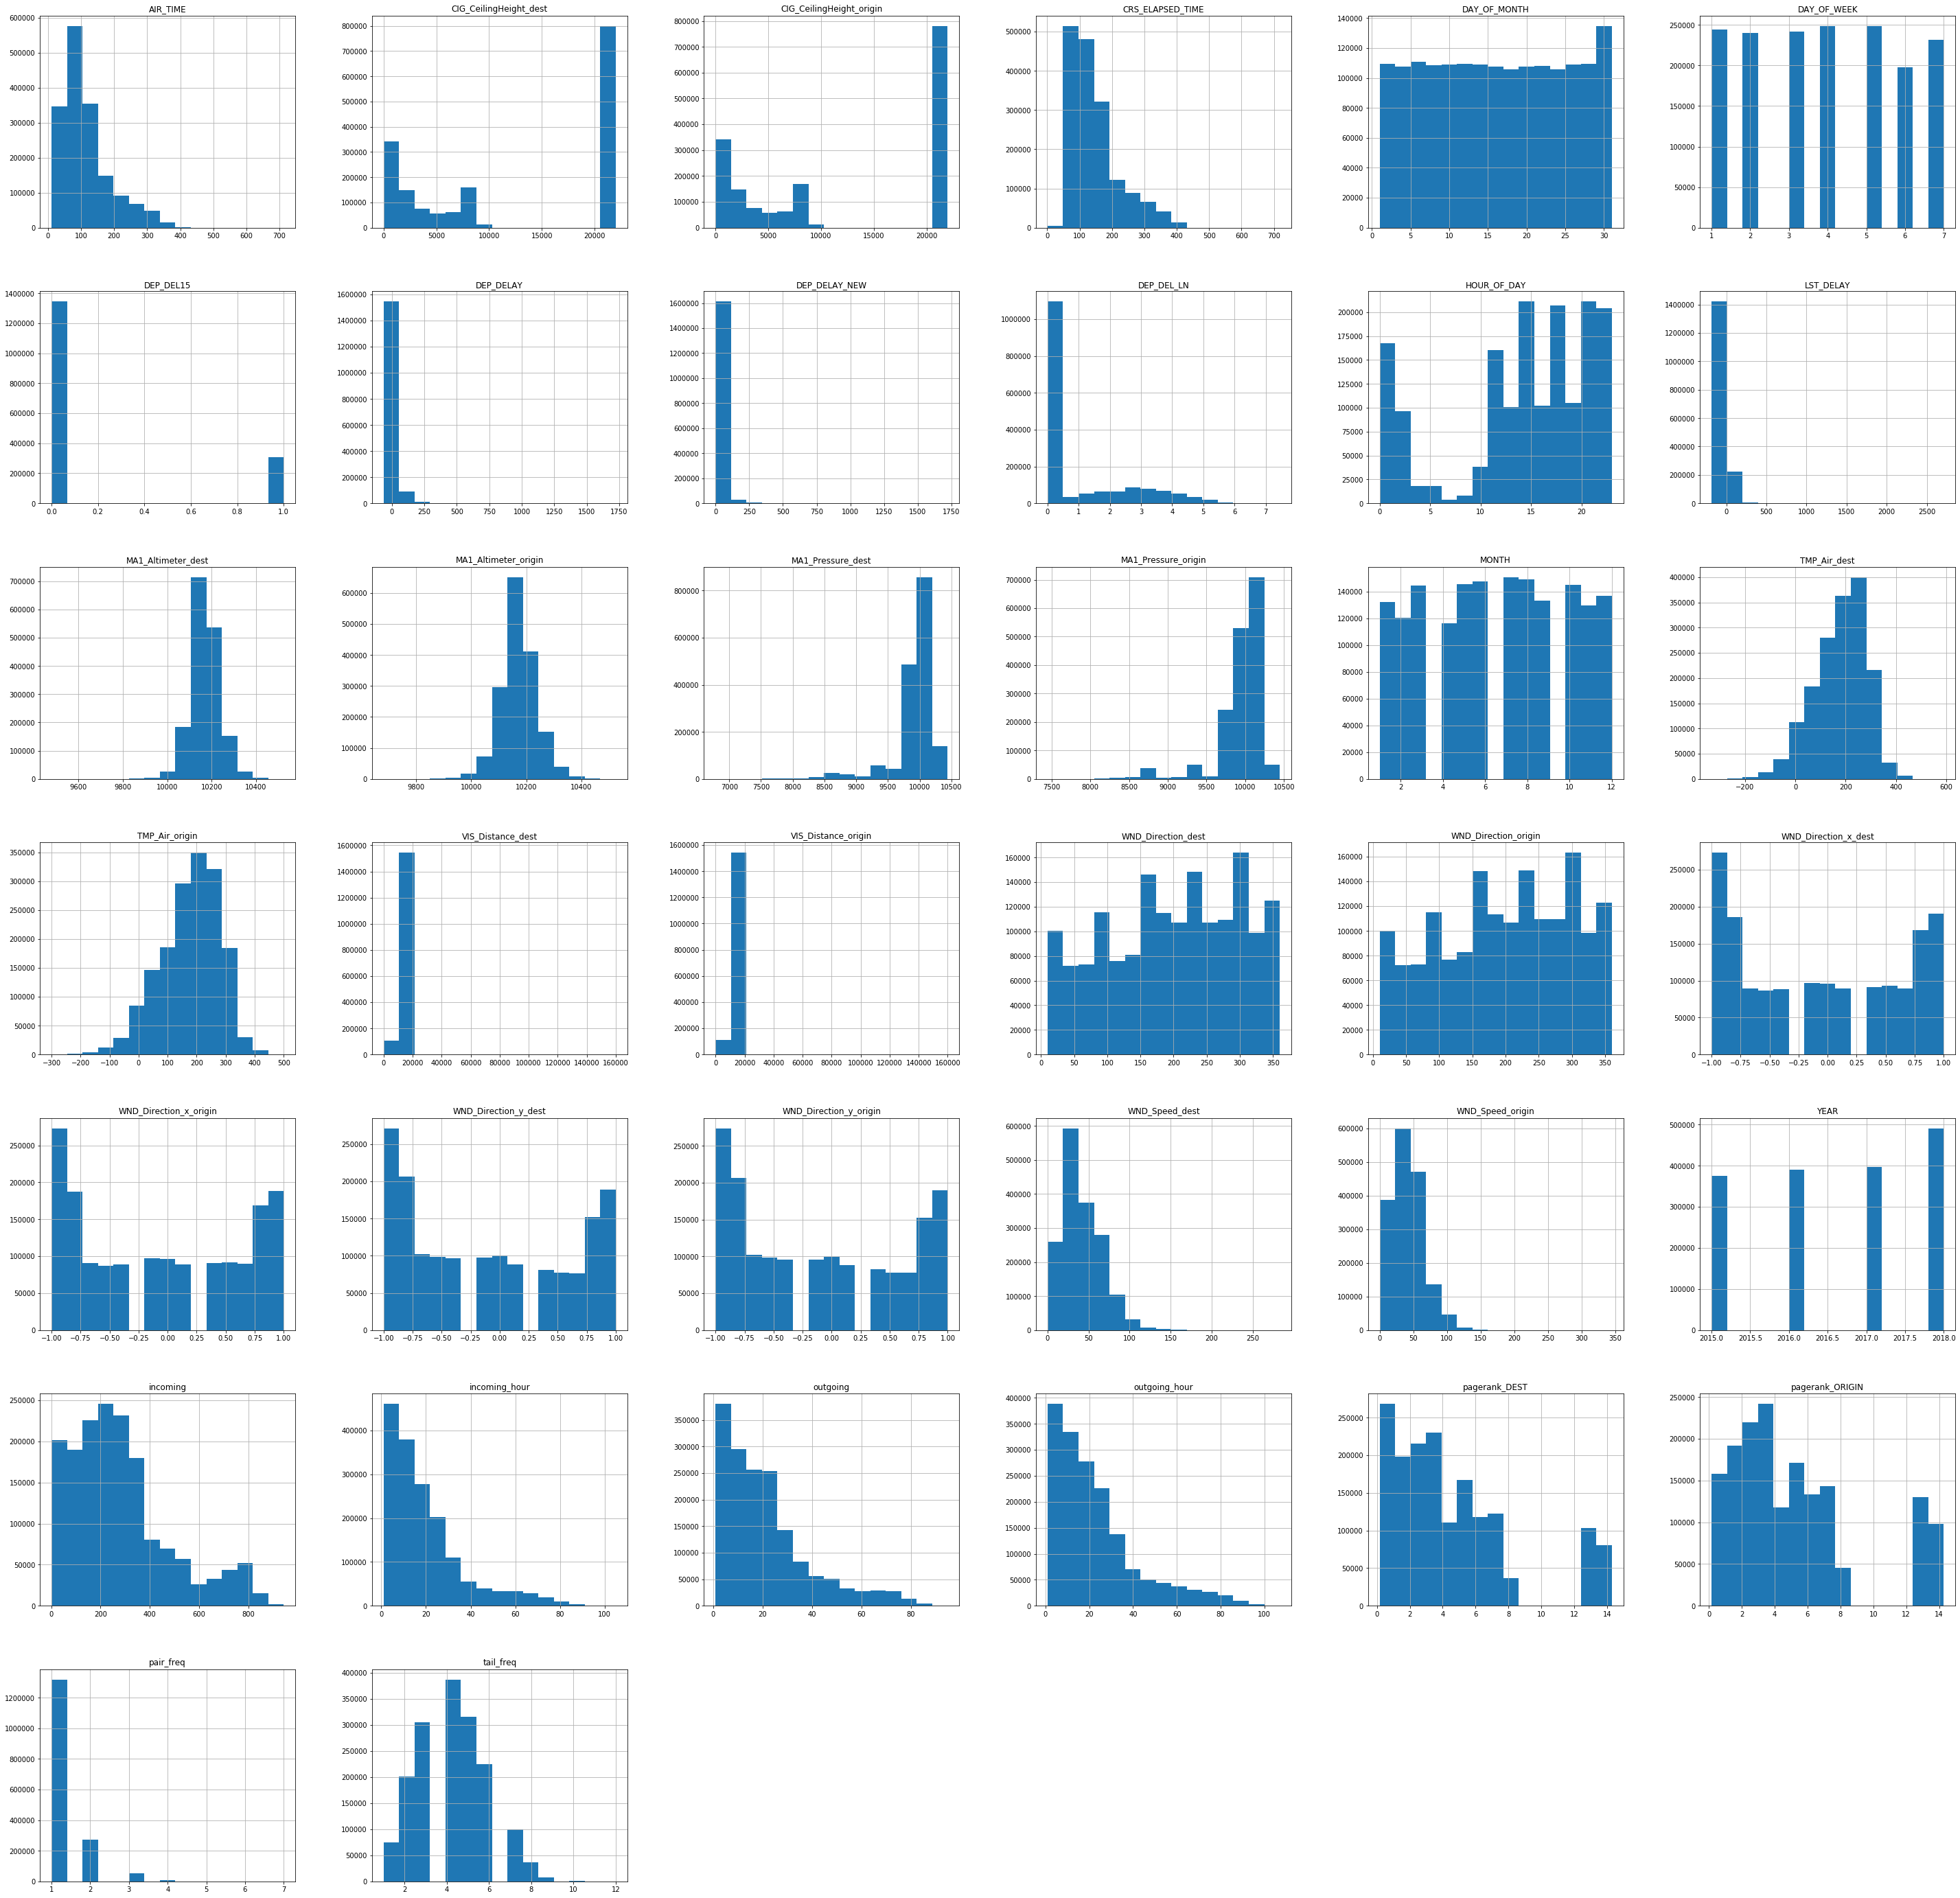

In [0]:
# Show each flight feature distribution
airlines_df = DF_train_shishir.sample(withReplacement=False, fraction=0.1).toPandas()
FIELDS = airlines_df.columns
airlines_df[FIELDS].hist(figsize=(50,50), bins=15)
display(plt.show())

In [0]:
import plotly.figure_factory as ff
import plotly.express as px

DF_train_shishir = DF_train_shishir.withColumn("lat_origin", DF_train_shishir["lat_origin"].cast(types.DoubleType()))
DF_train_shishir = DF_train_shishir.withColumn("lon_origin", DF_train_shishir["lon_origin"].cast(types.DoubleType()))
DF_train_shishir = DF_train_shishir.withColumn("lat_dest", DF_train_shishir["lat_dest"].cast(types.DoubleType()))
DF_train_shishir = DF_train_shishir.withColumn("lon_dest", DF_train_shishir["lon_dest"].cast(types.DoubleType()))
DF_train_shishir.registerTempTable("DF_tab")

DF_Airports = sqlContext.sql("SELECT DEST, lon_dest, lat_dest, count(*) as count  FROM DF_tab  group by DEST, lon_dest, lat_dest ").toPandas()
fig = px.scatter_mapbox(data_frame=DF_Airports, lon="lon_dest", lat="lat_dest",  hover_name="DEST", hover_data=["DEST", "count"], color_discrete_sequence=["fuchsia"], zoom=2.8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(title_text='Airports across USA')
fig.show()

Out[17]:

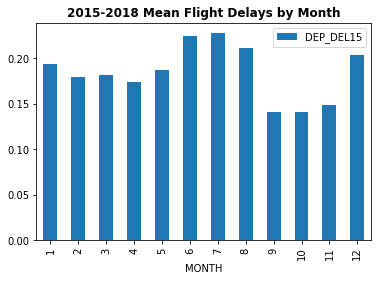

Text(0.5, 1.0, '2015-2018 Mean Flight Delays by Month')

In [0]:
# Average number of delayed flights per month
grouped = airlines_df[['DEP_DEL15', 'MONTH']].groupby('MONTH').mean()
# plot average delays by month
grouped.plot(kind='bar')
plt.title('2015-2018 Mean Flight Delays by Month', fontweight="bold")

Out[18]:

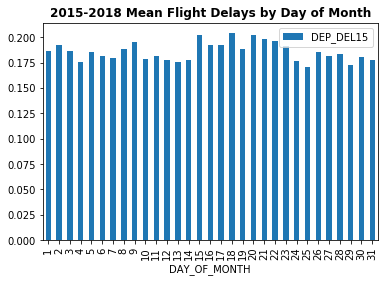

Text(0.5, 1.0, '2015-2018 Mean Flight Delays by Day of Month')

In [0]:
# Average number of delayed flights per day of month
grouped = airlines_df[['DEP_DEL15', 'DAY_OF_MONTH']].groupby('DAY_OF_MONTH').mean()

# plot average delays by day of month
grouped.plot(kind='bar')
plt.title('2015-2018 Mean Flight Delays by Day of Month', fontweight="bold")

Out[19]:

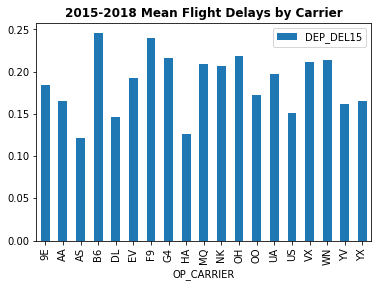

Text(0.5, 1.0, '2015-2018 Mean Flight Delays by Carrier')

In [0]:
# Average number of delayed flights per carrier and filter based on carriers
grouped = airlines_df[['DEP_DEL15', 'OP_CARRIER']].groupby('OP_CARRIER').mean()

# Plot carriers by delay 
grouped.plot(kind='bar')
plt.title('2015-2018 Mean Flight Delays by Carrier', fontweight="bold")

Out[20]:

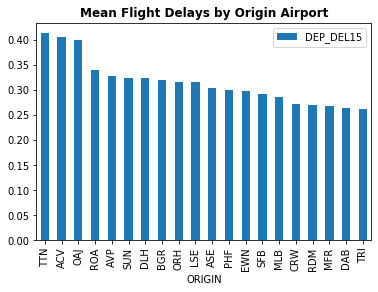

Text(0.5, 1.0, 'Mean Flight Delays by Origin Airport')

In [0]:
# Average number of delayed flights per origin airport 
# with more than 15 records
grouped = airlines_df[['DEP_DEL15', 'ORIGIN']].groupby('ORIGIN').filter(lambda x: len(x)>15)
grouped1 = grouped.groupby('ORIGIN').mean()
# display top 20 origin airports by delay
grouped1.sort_values(['DEP_DEL15'], ascending=False)[:20].plot(kind='bar')
plt.title('Mean Flight Delays by Origin Airport', fontweight="bold")

In [0]:
display(DF_train_shishir.groupBy("YEAR").count())

YEAR,count
2018,4917500
2015,3755167
2016,3884039
2017,3971399


In [0]:
DF_train_shishir = DF_train_shishir.where('DEP_DELAY >= -31 AND DEP_DELAY < 1441')

In [0]:
display(DF_train_shishir.describe())

summary,FL_DATE,PAIR,HOUR_OF_DAY,TAIL_NUM,ORIGIN,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,AIR_TIME,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,DEP_DELAY,DEP_DEL_LN,DEP_DEL15,DEP_DELAY_NEW,CRS_ELAPSED_TIME,LST_DELAY,incoming_hour,outgoing_hour,state_origin,lat_origin,lon_origin,state_dest,lat_dest,lon_dest,WND_Direction_origin,WND_Speed_origin,CIG_CeilingHeight_origin,VIS_Distance_origin,TMP_Air_origin,MA1_Altimeter_origin,MA1_Pressure_origin,WND_Direction_x_origin,WND_Direction_y_origin,WND_Direction_dest,WND_Speed_dest,CIG_CeilingHeight_dest,VIS_Distance_dest,TMP_Air_dest,MA1_Altimeter_dest,MA1_Pressure_dest,WND_Direction_x_dest,WND_Direction_y_dest,outgoing,incoming,tail_freq,pair_freq,pagerank_ORIGIN,pagerank_DEST
count,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16527901,16406996,16527662,16527830,16527850,16527812,16527640,16527281,16406996,16406996,16381280,16527459,16527617,16527684,16527616,16527547,16526994,16381280,16381280,16527901,16527901,16527901,16527901,16527901,16527901
mean,null,null,14.126801279847937,8806.404255319148,null,2016.6081262224404,6.57137945102648,15.718389044077648,3.9299713254574793,null,115.67782273139221,null,null,null,9.728927103326672,0.9650342306459914,0.18552513111011495,12.551696794408437,145.3223316741793,5.41319693287127,19.038932469404312,22.89063608258544,null,36.940123017707286,-93.34614380493436,null,36.99248822057627,-93.62864821477051,197.0103628354636,40.65692751945193,12188.340993705768,15194.932268746388,178.5201943850765,10171.580428179705,9949.414327075337,-0.05952028749987089,-0.09624341746215144,197.35499960931014,40.45251456984404,12358.98112553068,15215.442792771208,177.9417939647194,10170.94057920392,9942.21287585631,-0.05597915655122362,-0.09714380752865533,21.322378201563527,279.8591900447613,4.1927625897565575,1.247616258108032,5.216234964976942,4.629432508000911
stddev,null,null,6.902028257198224,1.9194485595661939,null,1.1347928011586947,3.39709287896696,8.830091203818457,1.9847815213226292,null,73.31618215364317,null,null,null,40.087299156149314,1.5321742981862807,0.38872299389043435,39.05335891994758,76.11278243633906,31.058379472815137,17.205971071124374,19.044256563832487,null,5.438528021322381,17.140553706596798,null,5.516322363297216,17.427167001252773,98.47915695574636,24.115555552534154,9531.31817081112,2816.1756200177774,102.03898787464219,63.68410153662379,311.58626824342116,0.7044264010180117,0.700698255805644,98.69258070907227,24.37567467925842,9565.403069454313,2798.5038041641756,102.43002560321143,63.82800741185846,328.5841579615185,0.7054378142947133,0.6998478156939993,17.714839703612775,200.38162182139206,1.6712873750532673,0.5420703439786009,3.9310317089047926,3.8151248334499024
min,2015-01-01,ABE-ATL,0,215NV,ABE,2015,1,1,1,9E,6.0,AK,ABE,AK,-31.0,0.0,0.0,0.0,-99.0,-183.0,1,1,AK,21.324,-100.757,AK,21.324,-100.757,4,0,0,0,-320,9655,7443,-1.0,-1.0,2,0,0,0,-344,9479,6700,-1.0,-1.0,1,1,1,1,0.16793927447206913,0.16076488878541276
max,2018-12-31,XNA-VPS,23,PLANET,XNA,2018,12,31,7,YX,723.0,WY,YNG,WY,1440.0,7.272398392570047,1.0,1440.0,718.0,2710.0,105,107,WY,61.169,-99.467,WY,61.169,-99.467,360,443,22000,160000,590,10528,10446,1.0,1.0,360,443,22000,160000,590,10528,10446,1.0,1.0,95,944,12,7,14.276905975254758,14.276905975254758


In [0]:
# Finding the number of on-time / early flights vs. delayed flights
print ("On-time / early flights: %d" % airlinesGraph.edges.filter("DEP_DELAY <= 15").count())
print ("Delayed flights: %d" % airlinesGraph.edges.filter("DEP_DELAY > 15").count())

On-time / early flights: 141296
Delayed flights: 515345

In [0]:
# Finding the avergaes and longest delay
longestDelay = airlinesGraph.edges.groupBy().max("DEP_DELAY")
averageDelay = airlinesGraph.edges.groupBy().mean("DEP_DELAY")
print("Longest Delay", longestDelay.show(1))
print("Average Delay", averageDelay.show(1))

+--------------+
max(DEP_DELAY)|
+--------------+
 2710.0|
+--------------+

Logest Delay None
+------------------+
 avg(DEP_DELAY)|
+------------------+
104.37588423506908|
+------------------+

Average Delay None

In [0]:
# Find the trip between Origin and Dest airports has top delayed flights 
topTrips = airlinesGraph.edges.groupBy("src", "dst").agg(f.count("DEP_DELAY").alias("trips")) 
display(topTrips.orderBy(topTrips.trips.desc()).limit(20))

src,dst,trips
LAX,JFK,445
LGA,ORD,436
MCO,JFK,424
ORD,ATL,419
FLL,JFK,413
LGA,ATL,413
LAX,SFO,411
EWR,ATL,406
SFO,JFK,403
ORD,LGA,399


In [0]:
len(DF_train_shishir.columns)

Out[5]: 55

In [0]:
cat_features = [x for (x,dataType) in DF_train_shishir.dtypes if dataType == 'string']
num_features = [x for (x,dataType) in DF_train_shishir.dtypes if ((dataType == 'int' or dataType == 'double' or dataType == 'bigint') & (x != 'DEP_DELAY') & (x != 'DEP_DEL15') & (x != 'DEP_DEL_LN') & (x != 'DEP_DELAY_NEW')) ]

In [0]:
print(cat_features, num_features)

['FL_DATE', 'PAIR', 'TAIL_NUM', 'ORIGIN', 'OP_CARRIER', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'state_origin', 'lat_origin', 'lon_origin', 'state_dest', 'lat_dest', 'lon_dest'] ['HOUR_OF_DAY', 'YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'AIR_TIME', 'CRS_ELAPSED_TIME', 'LST_DELAY', 'incoming_hour', 'outgoing_hour', 'WND_Direction_origin', 'WND_Speed_origin', 'CIG_CeilingHeight_origin', 'VIS_Distance_origin', 'TMP_Air_origin', 'MA1_Altimeter_origin', 'MA1_Pressure_origin', 'WND_Direction_x_origin', 'WND_Direction_y_origin', 'WND_Direction_dest', 'WND_Speed_dest', 'CIG_CeilingHeight_dest', 'VIS_Distance_dest', 'TMP_Air_dest', 'MA1_Altimeter_dest', 'MA1_Pressure_dest', 'WND_Direction_x_dest', 'WND_Direction_y_dest', 'outgoing', 'incoming', 'tail_freq', 'pair_freq', 'pagerank_ORIGIN', 'pagerank_DEST']

In [0]:
len(cat_features)

Out[8]: 14

In [0]:
len(num_features)

Out[9]: 34

In [0]:
train_df_sample = DF_train_shishir.sample(withReplacement=False, fraction=0.001).toPandas()
len(train_df_sample.columns)

Out[10]: 55

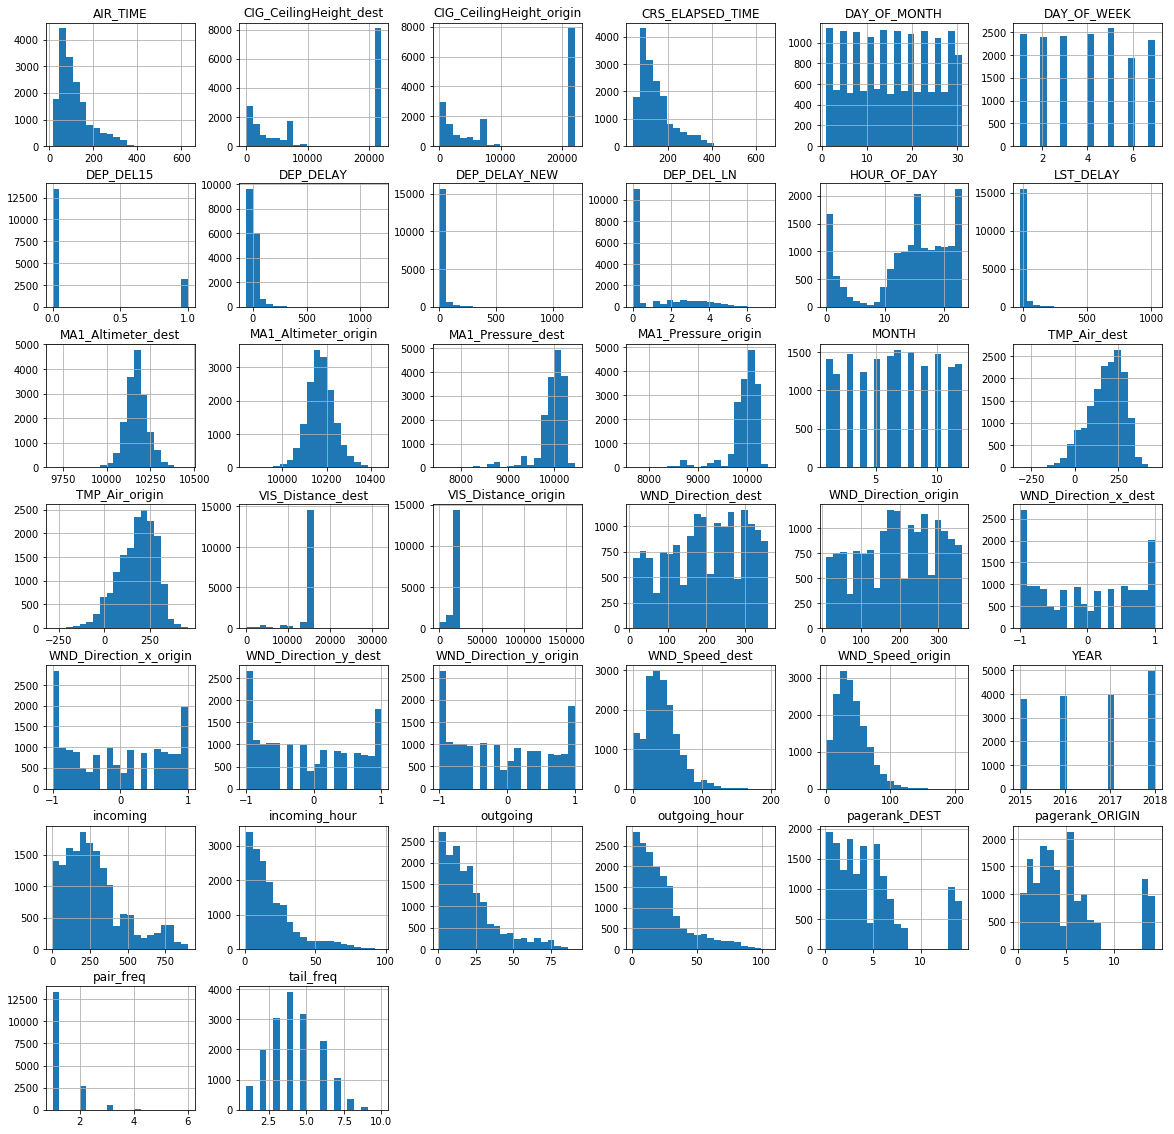

In [0]:
import matplotlib.pyplot as plt
FIELDS = DF_train_shishir.columns
train_df_sample[FIELDS].hist(figsize=(20,20), bins=20)
display(plt.show())

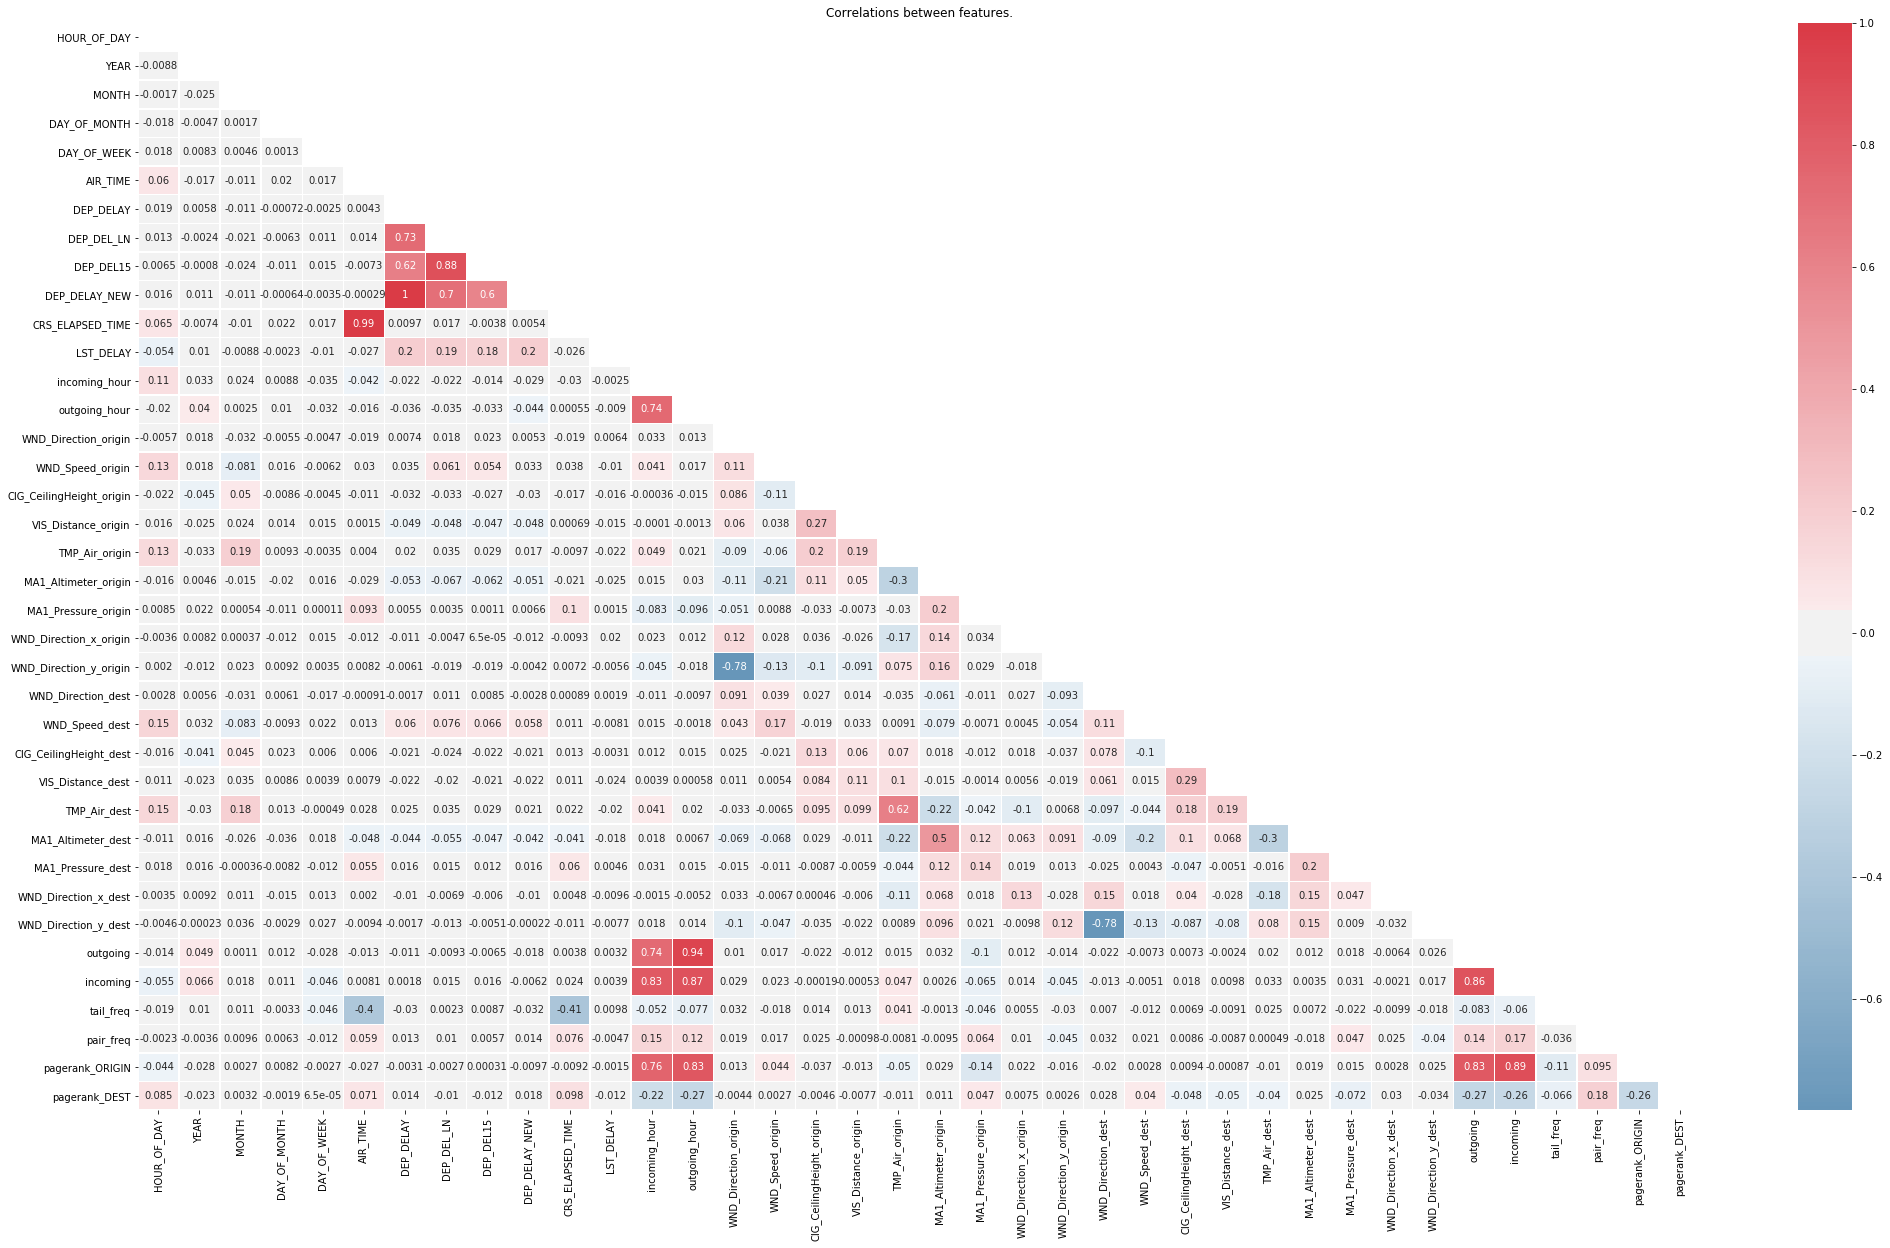

In [0]:
# plot heatmap for correlations matrix
FIELDS = DF_train_shishir.columns
corr = train_df_sample[FIELDS].corr()
fig, ax = plt.subplots(figsize=(35, 20))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, annot=True)
plt.title("Correlations between features.")
display(plt.show())

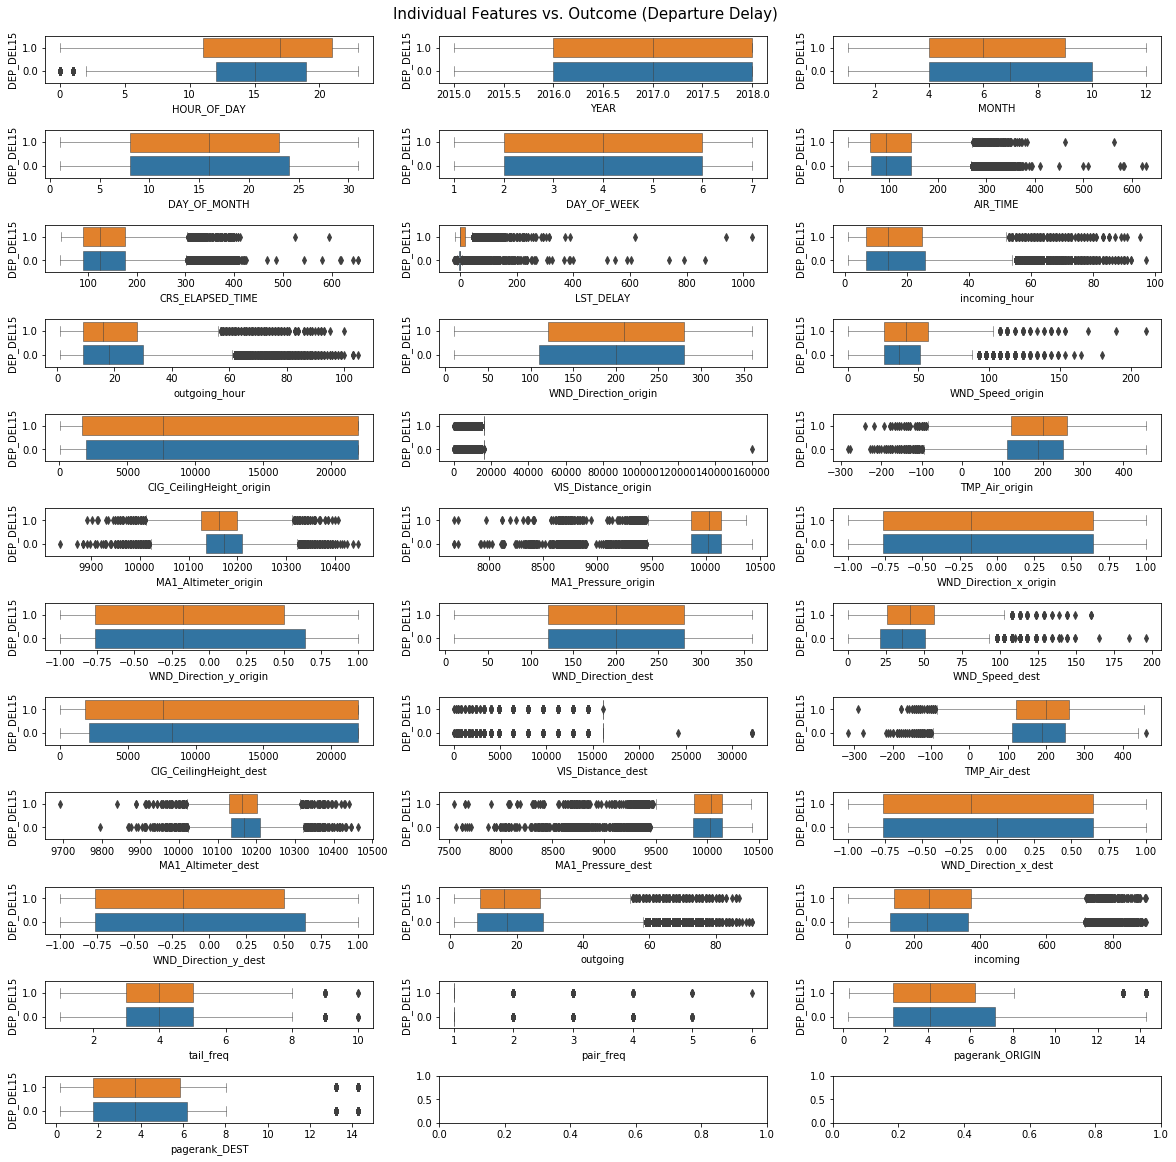

In [0]:
FIELDS = num_features
fig, ax_grid = plt.subplots(12, 3, figsize=(20,20))
fig.subplots_adjust(hspace=1)
y = train_df_sample['DEP_DEL15']
for idx, feature in enumerate(list(FIELDS[:])):
    x = train_df_sample[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (Departure Delay)", fontsize=15, y=0.9)
display(plt.show())

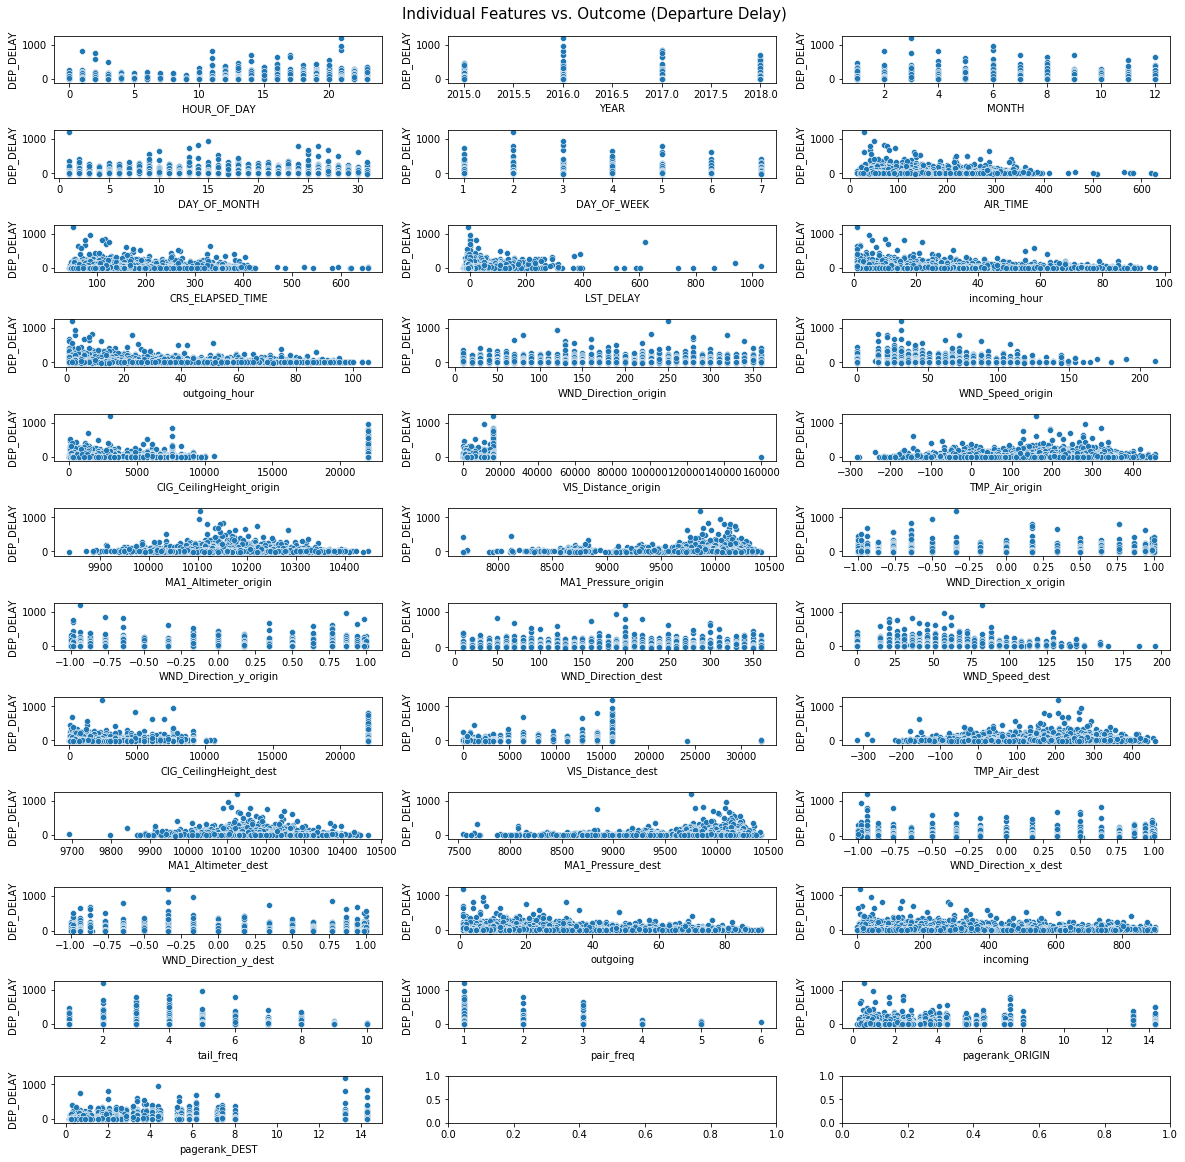

In [0]:
FIELDS = num_features
fig, ax_grid = plt.subplots(12, 3, figsize=(20,20))
fig.subplots_adjust(hspace=1)
y = train_df_sample['DEP_DELAY']
for idx, feature in enumerate(list(FIELDS[:])):
    x = train_df_sample[feature]
    sns.scatterplot(x, y, ax=ax_grid[idx//3][idx%3], linewidth=.5)
    ax_grid[idx//3][idx%3]
fig.suptitle("Individual Features vs. Outcome (Departure Delay)", fontsize=15, y=0.9)
display(plt.show())

# 4. Algorithms Exploration and Implementation

- We have explored and impelmented four algorithms including Logistics Regression, Decision Tree, Random Forest and Gradient Boosting. We evaluated each model accuracy and confusion matrics and False Positive value is the one that we want to reduce as it has the highest impacts from business perspective.

#### 4.1 Feature Selection

In [0]:
num_features = [x for (x,dataType) in DF_train_shishir.dtypes if ((dataType == 'int' or dataType == 'double' or dataType == 'bigint') & (x != 'DEP_DELAY') & (x != 'DEP_DEL15') & (x != 'DEP_DEL_LN') & (x != 'DEP_DELAY_NEW')) ]

In [0]:
num_features = ['HOUR_OF_DAY','LST_DELAY','WND_Speed_origin','outgoing_hour','MA1_Altimeter_origin','TMP_Air_origin','tail_freq','pagerank_DEST','MA1_Altimeter_dest']

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorSlicer
indexer = StringIndexer(inputCol="OP_CARRIER", outputCol="op_carrier_index",handleInvalid='skip')
encoder = OneHotEncoder(inputCol="op_carrier_index", outputCol="op_carrier_encode")
slicer = VectorSlicer(inputCol="op_carrier_encode", outputCol="op_carrier_slice", indices=[0])
pca = PCA(k=3, inputCol = "op_carrier_encode", outputCol = "op_carrier_pca")

assembler_num = VectorAssembler(inputCols=num_features, outputCol="vector", handleInvalid='skip')
#ss = StandardScaler(inputCol = "vector", outputCol = "scaled_vector")
assembler_all = VectorAssembler(inputCols=['vector','op_carrier_slice'], outputCol="features", handleInvalid='skip')

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer, encoder, slicer, pca, assembler_num, assembler_all])
pipelineModel = pipeline.fit(DF_train_shishir)
DF_train_shishir_transformed = pipelineModel.transform(DF_train_shishir)
DF_test_shishir_transformed = pipelineModel.transform(DF_test_shishir)

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="DEP_DEL15", featuresCol="features", seed = 333, numTrees=10, maxDepth=10, cacheNodeIds = True)
rfModel = rf.fit(DF_train_shishir_transformed)
rf_predict_train = rfModel.transform(DF_train_shishir_transformed)
print(rfModel.featureImportances)

(10,[0,1,2,3,4,5,6,7,8,9],[0.31325062420315314,0.5536443894067513,0.011940302409769614,0.022118513353595964,0.0184247530521915,0.010013989772465962,0.020434288830022174,0.010922358871010968,0.011769582206999744,0.027481197894039622])

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))
var_list = ExtractFeatureImp(rfModel.featureImportances, DF_train_shishir_transformed, "features")
var_list

Out[24]:

,idx,name,score
1,1,vector_LST_DELAY,0.553644
0,0,vector_HOUR_OF_DAY,0.313251
9,9,op_carrier_slice_WN,0.027481
3,3,vector_outgoing_hour,0.022119
6,6,vector_tail_freq,0.020434
4,4,vector_MA1_Altimeter_origin,0.018425
2,2,vector_WND_Speed_origin,0.011940
8,8,vector_MA1_Altimeter_dest,0.011770
7,7,vector_pagerank_DEST,0.010922
5,5,vector_TMP_Air_origin,0.010014


In [0]:
computeConfusionMatrix(rf_predict_train)

+---------+----------+--------+
DEP_DEL15|prediction| count|
+---------+----------+--------+
 1.0| 1.0| 448765|
 0.0| 1.0| 183774|
 1.0| 0.0| 2617424|
 0.0| 0.0|13277244|
+---------+----------+--------+

n precision: 0.709
n recall: 0.146
n accuracy: 0.831
n F1 score: 0.243

#### 4.2 Basic Models

##### 4.2.1 Logistic Regression

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="DEP_DEL15", featuresCol="features", maxIter=20)
logModel=lr.fit(DF_train_shishir_transformed)
log_predict_train = logModel.transform(DF_train_shishir_transformed)
log_predict_test = logModel.transform(DF_test_shishir_transformed)

In [0]:
computeConfusionMatrix(log_predict_test)

+---------+----------+-------+
DEP_DEL15|prediction| count|
+---------+----------+-------+
 1.0| 1.0| 37599|
 0.0| 1.0| 32151|
 1.0| 0.0| 919867|
 0.0| 0.0|4092514|
+---------+----------+-------+

n precision: 0.539
n recall: 0.039
n accuracy: 0.813
n F1 score: 0.073

##### 4.2.2 Linear Regression

In [0]:
from pyspark.ml.regression import LinearRegression
linr = LinearRegression(labelCol="DEP_DELAY", featuresCol="features", regParam=0.2, elasticNetParam=1.0)
linrModel = linr.fit(DF_train_shishir_transformed)
linr_predict_train = linrModel.transform(DF_train_shishir_transformed)
linr_predict_test = linrModel.transform(DF_test_shishir_transformed)
print(linrModel.summary.r2)
print(linrModel.coefficients)

0.0446972540715469
[0.04162308385611378,0.24257135879129252,0.07758197396864029,-0.0535002379891588,-0.012639340506082451,0.0011139587695022876,-0.6775868191447371,0.0,-0.016698540852623633,0.30353218782022096]

#### 4.3 Advanced Models

In [0]:
training = spark.read.parquet("dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_train_shishir.parquet")
test = spark.read.parquet("dbfs:/mnt/mids-w261/final_project_team_26/airlines_weather_data_test_shishir.parquet")

In [0]:
header=['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','HOUR_OF_DAY','outgoing','incoming','CRS_ELAPSED_TIME','LST_DELAY','incoming_hour','outgoing_hour', 'WND_Direction_x_origin','WND_Direction_y_origin', 'WND_Speed_origin', 'CIG_CeilingHeight_origin', 'VIS_Distance_origin', 'TMP_Air_origin', 'MA1_Altimeter_origin', 'MA1_Pressure_origin','WND_Direction_x_dest','WND_Direction_y_dest', 'WND_Speed_dest', 'WND_Speed_dest', 'CIG_CeilingHeight_dest', 'VIS_Distance_dest', 'TMP_Air_dest', 'MA1_Altimeter_dest', 'MA1_Pressure_dest','pair_freq','pagerank_ORIGIN','pagerank_DEST']
header.append('tail_freq')
header.append('OP_CARRIER_index')
header.append('ORIGIN_index')
header.append('DEST_index')
header.remove('YEAR')
header.remove('DAY_OF_MONTH')

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(training) for column in ['OP_CARRIER','ORIGIN', 'DEST'] ]
assembler = VectorAssembler(inputCols=header, outputCol="features_raw", handleInvalid='skip')
ss = StandardScaler(inputCol = "features_raw", outputCol = "features")
pipeline = Pipeline(stages=indexers+[assembler,ss])
trainingData = pipeline.fit(training).transform(training)
#display(trainingData)

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(test) for column in ['OP_CARRIER','ORIGIN', 'DEST'] ]
assembler = VectorAssembler(inputCols=header, outputCol="features_raw", handleInvalid='skip')
ss = StandardScaler(inputCol = "features_raw", outputCol = "features")
pipeline = Pipeline(stages=indexers+[assembler,ss])
testData = pipeline.fit(test).transform(test)
#display(testData)

In [0]:
#Let us check whether their is imbalance in the dataset
dataset_size=float(trainingData.select("DEP_DEL15").count())
numPositives=trainingData.select("DEP_DEL15").where('DEP_DEL15 == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))
#Imbalancing handling
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

trainingData=trainingData.withColumn("classWeights", f.when(trainingData.DEP_DEL15 == 1,BalancingRatio).otherwise(1-BalancingRatio))
testData=testData.withColumn("classWeights", f.when(testData.DEP_DEL15 == 1,BalancingRatio).otherwise(1-BalancingRatio))

The number of ones are 3008483
Percentage of ones are 18.491858557534684
BalancingRatio = 0.8150814144246532

##### 4.3.1 Decision Tree

A decision tree is a simple algorithm that essentially mimics a flowchart making them easy to interpret. A tree is composed out of the root-node, several tree-nodes and leaves. Essentially every node (including the root-node) splits the data set in subsets. Each split resembles an essential feature-specific question is a certain condition present or absent? Answering all those questions, until the bottom layer of the tree is reached, yields a prediction for the current sample.

In [0]:
# fit the model with training data and preidct with testing data 
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'DEP_DEL15',
                            maxDepth = 10, maxBins=300, impurity='gini')
dtModel = dt.fit(trainingData)
dtpredict_train = dtModel.transform(trainingData)
dtpredict_test = dtModel.transform(testData)

In [0]:
# print the confusion matrix of Decision tree for training and testing data
print ("Decision Tree Confusion Matrix -training data:")
computeConfusionMatrix(dtpredict_train)
print ("Decision Tree Confusion Matrix -test data:")
computeConfusionMatrix(dtpredict_test)

Decision Tree Confusion Matrix -training data:
+---------+----------+--------+
DEP_DEL15|prediction| count|
+---------+----------+--------+
 1.0| 1.0| 534065|
 0.0| 1.0| 221913|
 1.0| 0.0| 2474418|
 0.0| 0.0|13038834|
+---------+----------+--------+

n precision: 0.706
n recall: 0.178
n accuracy: 0.834
n F1 score: 0.284
Decision Tree Confusion Matrix -testing data:
+---------+----------+-------+
DEP_DEL15|prediction| count|
+---------+----------+-------+
 1.0| 1.0| 145085|
 0.0| 1.0| 59586|
 1.0| 0.0| 795431|
 0.0| 0.0|4005042|
+---------+----------+-------+

n precision: 0.709
n recall: 0.154
n accuracy: 0.829
n F1 score: 0.253

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="DEP_DEL15")
dtpredict_train.select("DEP_DEL15","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(dtpredict_train)))
#print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))
print("The area under AUC for train set is {}".format(evaluator.evaluate(dtpredict_train), {evaluator.metricName: 'areaUnderROC'}))
#print("The area under AUC for test set is {}".format(evaluator.evaluate(predict_test), {evaluator.metricName: 'areaUnderROC'}))

+---------+--------------------+----------+--------------------+
DEP_DEL15| rawPrediction|prediction| probability|
+---------+--------------------+----------+--------------------+
 0.0| [136593.0,17129.0]| 0.0|[0.88857157726285...|
 0.0| [85853.0,21190.0]| 0.0|[0.80204216996907...|
 0.0|[1997095.0,284670.0]| 0.0|[0.87524131538523...|
 0.0|[1997095.0,284670.0]| 0.0|[0.87524131538523...|
 0.0|[2117712.0,404334.0]| 0.0|[0.83968016443792...|
+---------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.4187733885659897
The area under AUC for train set is 0.4187733885659897

##### 4.3.2 Random Forest

Random forest is a bagging (or bootstrap aggregating) method that builds decision trees simultaneously. Subsequently, it combines the predictions of the individual grown trees to provide a final prediction. A Random forest can be used for both regression and classification problems.

In [0]:
# fit the model with training data and preidct with testing data 
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'DEP_DEL15',
                            numTrees=20, maxDepth=15,  seed=42)
rfModel = rf.fit(trainingData)
rfpredict_train = rfModel.transform(trainingData)
rfpredict_test = rfModel.transform(testData)


In [0]:
# print the confusion matrix of Random Forest for training and testing data
print ("Random Forest Confusion Matrix -training data:")
computeConfusionMatrix(rfpredict_train)
print ("Random Forest Confusion Matrix -testing data:")
computeConfusionMatrix(rfpredict_test)

Random Forest Confusion Matrix -training data:
+---------+----------+--------+
DEP_DEL15|prediction| count|
+---------+----------+--------+
 1.0| 1.0| 474953|
 0.0| 1.0| 132561|
 1.0| 0.0| 2533530|
 0.0| 0.0|13128186|
+---------+----------+--------+

n precision: 0.782
n recall: 0.158
n accuracy: 0.836
n F1 score: 0.263
Random Forest Confusion Matrix -testing data:
+---------+----------+-------+
DEP_DEL15|prediction| count|
+---------+----------+-------+
 1.0| 1.0| 117472|
 0.0| 1.0| 37759|
 1.0| 0.0| 823044|
 0.0| 0.0|4026869|
+---------+----------+-------+

n precision: 0.757
n recall: 0.125
n accuracy: 0.828
n F1 score: 0.214

##### 4.3.3 Gradient Boosting

Gradient boosting is one of the most popular machine learning algorithms. The main idea of boosting is to build weak predictors subsequently and use information of the previous built predictors to enhance performance of the model. For Gradient boosting these predictors are decision trees. In comparison to Random forest, the depth of the decision trees that are used is often a lot smaller in Gradient boosting.

In [0]:
# fit the model with training data and preidct with testing data 
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='DEP_DEL15',
                    maxDepth=10, maxIter=10, seed=32)
gbtModel = gbt.fit(trainingData)
gbtpredict_train = gbtModel.transform(trainingData)
gbtpredict_test = gbtModel.transform(testData)

In [0]:
# print the confusion matrix of GBT for training and testing data
print ("Gradient Boosting Confusion Matrix -training data:")
computeConfusionMatrix(gbtpredict_train)
print ("Gradient Boosting Confusion Matrix -testing data:")
computeConfusionMatrix(gbtpredict_test)

Gradient Boosting Confusion Matrix -training data:
+---------+----------+--------+
DEP_DEL15|prediction| count|
+---------+----------+--------+
 1.0| 1.0| 582650|
 0.0| 1.0| 219556|
 1.0| 0.0| 2425833|
 0.0| 0.0|13041191|
+---------+----------+--------+

n precision: 0.726
n recall: 0.194
n accuracy: 0.837
n F1 score: 0.306
Gradient Boosting Confusion Matrix -testing data:
+---------+----------+-------+
DEP_DEL15|prediction| count|
+---------+----------+-------+
 1.0| 1.0| 157033|
 0.0| 1.0| 60904|
 1.0| 0.0| 783483|
 0.0| 0.0|4003724|
+---------+----------+-------+

n precision: 0.721
n recall: 0.167
n accuracy: 0.831
n F1 score: 0.271

# 5. Performance and Scalability

During the project, we have some learning w.r.t. Performance and scalability like:
Caching and persisting data as parquet files is very important especially when working with large data sets. 
While joining data, instead of a monolithic join, building incremental joins helped us avoid bottlenecks.
Also usage of intermediate tables helped. 

We couldn’t evaluate the model performance for scalability because of the shared cluster setup we have. Also we couldn’t try more grid search like techniques for hyperparameter tuning.

# 6. Limitations and Challenges

The following are the limitations and challenges that we encountered during the project cycle, they are:

- There is some data loss after the joins because of missing weather and stations data. 
- Also because of shared cluster with various concurrently running jobs:
    * Couldn’t evaluate model performance w.r.t. time taken. 
    * There is scope to get improved model performance if we explore more hyperparameter tuning via grid search.

# 7. Conclusion  
In conclusion, our results show Random Forest model with low FP and FN , and high precision outperform the other models. From business perspective, it  would help to reduce the cost and sustain customer satisfaction

Confusion Matrix of each algorithm

|         |          |        |          |         | Predicted |        |          |        |          |
|:-------:|:--------:|:------:|:--------:|:-------:|:---------:|--------|----------|--------|----------|
|         |          | LogReg |          |    DT   |           | RF     |          | GBT    |          |
|         |          |  Delay | No Delay | Delay   |  No Delay |  Delay | No Delay |  Delay | No Delay |
| Actual  |   Delay  | 104206 |  2961920 |  534065 |  2474418  | 474953 |  2533530 | 582650 |  2425833 |
|         | No Delay |  88712 | 13372165 |  221913 |  13038834 | 132561 | 13128186 | 219556 | 13041191 |

Evaluation Metrics of each algorithm

|   Model   |  LogReg  |  LogReg |     DT    |    DT   |    RF    |    RF    |    GBT    |   GBT   |
|:---------:|:--------:|:-------:|:---------:|:-------:|:--------:|:--------:|:---------:|:-------:|
|  Metrics  | training | testing | training  | testing | training | testing  | training  | testing |
| precision |   0.54   |  0.539  |   0.706   |  0.709  |   0.782  |   0.757  |   0.726   |  0.721  |
|   recall  |   0.034  |  0.039  |   0.178   |  0.154  |   0.158  |   0.125  |   0.194   |  0.167  |
|     F1    |   0.064  |  0.073  |   0.284   |  0.253  |   0.263  |   0.214  |    0.306   |  0.231  |
|  accuracy |   0.815  |  0.813  |   0.834   |  0.829  |   0.836  |   0.828  |   0.837   |  0.830  |

# 8. Application of Course Concepts 

Our team has applied number of concepts and technique that we learned in this course, they are:  
- Spark framework with RDD/DataFrame which is automatically distributes the datasets contained in RDDs/DataFrames across the clusters and parallelizes the computation of ML algorithms in training, testing and evaluation;  
- Graph algorithm and large scale graph processing, Pageranks to derive additional features which are used for our modeling; as wells as exploring the results of number of our predefined research questions (Q2-Q5) other than predicting flights delay question;  
- Used one hot encoding and normalization for categorical and numerical features; class imbalance management using classWeights to allow our models training and testing in an more efficient and optimized approach;  
- In terms of algorithms, we have implemented logistic regression, linear regression and decision trees as well as random forest and gradient boosting trees for our models evaluation. In particular, trees algorithm are expected to achieve a good result in a more parallelizable and scalable manners though we are not able to compare amongst all algorithms timing due to the shared infrastructure resources, i.e. we are not able to find and run the performance in a controlled environment.

# 9. Reference  
1. U.S. Passenger Carrier Delay Costs
> https://www.airlines.org/dataset/per-minute-cost-of-delays-to-u-s-airlines/#

2. Bureau of Transportation Statistics  
> https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236   
> https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations  

3. Matching station codes to airports:
> http://dss.ucar.edu/datasets/ds353.4/inventories/station-list.html  
> https://www.world-airport-codes.com/  

4. UC Berkeley School of Information, MIDS W261 - Fall 2020, all course materials  

5. Open flights data
> http://openflights.org